# 第7章 因果推論のための時系列解析

## 7.1 時系列解析を用いた因果推論の全体像

### 7.1.1 時系列解析と因果推論の関係

これまで結果変数や共変量、交絡因子に対して時間依存がないという仮定を置いていたが、時間依存性を考慮する因果推論も現実問題として存在する。

![図7.2](images/chap7/image.png)

時間変化を伴う因果効果の推定

* 処置が単体の場合: 特定の1つのイベントの効果を推定する(処置の前後の効果を検証)
  1. 処置群と対照群がそれぞれ存在する場合: DiD、SCを用いる事ができる
  2. 処置群しか存在しない場合: 時系列解析を用いる

     * イベントの効果検証: 実際の売上データに対して、イベント前の売上データを時系列モデルで学習。イベント以降の予測値を反実仮想として算出。予実差を因果効果とする。
* 処置が複数の場合:
  * 複数のメディアの効果検証: マーケティング・ミックスモデリング(Marketing Mix Modeling: MMM)を使用できる

### 7.1.2 時系列解析の活用

* 時系列解析
  * 予測: 売上や需要の将来予測など。予測精度が優先され解釈性が二の次になる
  * 因果推論: 時系列を伴う効果検証など。ここでは処置群のみが存在する場合において、単体施策と複数施策について考える
    * 単体施策: 対照群のデータを予測し、その予測値と実測値の差を因果効果とする
    * 複数施策: 回帰分析と同様に各施策の効果を推定し比較する

実務に活用するにあたって、特にマーケティングにおけるPDCAサイクルがある。

* Plan: 売上・需要予測(数理最適化を組み合わせル事例もある: 配車サービスDiDi)
* Do: レコメンドなどの準備された施策を実行
* Check: 因果推論などを用いて効果検証を行う
* Action: 今後の改善

## 7.2 時系列解析の全体像

### 7.2.1 時系列解析の概要

扱うデータの具体例: 経済データ(株価、為替など)、環境データ(気温、降水量など)

データサイエンスの科学的な貢献に以下の3つがある

* 記述(Description): この項
* 予測(prediction): [7.2.2~7.2.4項](#722-時系列解析の実行手順)
* 因果推論(counterfactual prediction): [7.3項以降](#73-時系列解析の因果推論への適用)

これに沿って時系列解析を説明する。

#### 記述

時系列解析で可視化・抽出すべき情報

1. 季節性/周期性: 一定の時間間隔で繰り返し現れるパターン

   年、月、週などの単位。花粉、四季
2. トレンド: 長期にわたり増加または減少する大まかな方向性
3. 外因性: イベント、祝日などの外部の要因が及ぼす性質

   例えば経済では、国内外の情勢や経済情景、天候、災害など
4. 自己相関: 異なる時点間の相関

   ある時系列データの特定の時間における値が、その前後の時間の値とどの程度相関があるかを示す統計量。

   自己相関関数(事項相関の度合いを表す)

   * $k$: 時間差
   * $R_k$: 時間差kのときの自己相関係数
   * $Cov(Y_t, Y_{t-k})$: 自己共分散
   * $Var(Y_t), Var(Y_{t-k})$: 分散

   $$
   R_k
   = \frac{Cov(Y_t, Y_{t-k})}
          {\sqrt{Var(Y_t)Var(Y_{t-k})}}
   $$

   自己相関係数は-1から1までの値を取る
5. ノイズ: 取り出したい情報以外の不要な情報

   なんの情報を取り出したいかによって、ノイズの具体的に定義は変わる。特に時系列解析ではホワイトノイズがよく使用される

   * ホワイトノイズ: 期待値0、分散が一定一定の自己相関を持たないノイズ

* 定常性:
  
  同時分布や同時分布や基本統計量の時間不変性に関するもの。
  
  何を不変とするかによって、弱定常性と強定常性に分類される
  * 弱定常性: 時系列データの以下のパラメータが時間差(ラグ)のみに依存する性質
    * 平均(期待値): $E[Y_t] = E[Y_{t-k}]$
    * 分散: $Var(Y_t) = Var(Y_{t-k})$
    * 共分散: $Cov(Y_t, Y_s) = Cov(Y_{t-k}, Y_{s-k})$
    
  * 強定常性: 弱定常性の3つのパラメータに加え、同時分布が時間差により変わらない性質
    * 同時分布: $p(Y_{t_1}, Y_{t_2}, \cdots Y_{t_n}) = p(Y_{t_1 + k}, Y_{t_2 + k}, \cdots Y_{t_n + k})$

    ![図7.10](images/chap7/image-1.png)

  最も基本的な強定常過程の例: 独立同一分布(independently and identically distributed: i.i.d.)系列。以下を満たす。

  各時点のデータが、
  1. 互いに独立
  2. かつ、同一の確率分布から生成される

* 非定常性: 弱定常性にも該当しないもの

定常性、非定常性は検定で確認可能
* Augmented Dickey Fuller(ADF)検定
* Kwiatkowski-Phillips-Schmidt-Shin(KPSS)検定
など

定常性を仮定することのメリット
* モデルのパラメータ推定が容易
* 定常性を持つ時系列は、未来の挙動の予測精度を高められる可能性が高い

非定常時系列データの扱いかた
* 簡易的な方法として時系列の差分を取るなど処理を行い、定常時系列に変換する方法
* 一方で非定常時系列をそのまま扱い、予測モデルを構築する方法もある

### 7.2.2 時系列解析の実行手順

#### 1. データ準備
十分な期間のデータが必要(季節性であれば数年分など)。だが、期間が長過ぎても良くない。例えばCovid-19などある時点で状況がガラッとかわっている場合などは予測精度が下がる場合がある。何にせよ背景知識が大事。

#### 2. 前処理、3. 学習・検証
第4章で解説した機械学習と同様(データ分割、学習、テスト)。

この際に可能であればクロスバリデーションとして、複数の学習期間とテスト期間を設定して精度検証を行う。時系列データでは過学習の検証時に複数の期間を検証する必要がある。

#### 4. 将来予測

必要な場合、学習モデルを用いて将来の予測値を算出。このとき、何時点先までを算出するかを指定する。

### 7.2.3 時系列モデルの種類

1. 分解可能なモデル
   * 構造時系列モデル: トレンド項や季節項など複数成分で表現される。構成要素毎に分解して予測する。 
2. 分解不可能なモデル: 分解部分がないので、SHAPや、前処理段階で説明変数に季節性を取り入れるなどを行う
   * AutoML: 予測のみであればAutoMLで実装できるので[7.2.4項](#724-PyCaretによる実装と具体的なフローの理解)で扱う

因果推論を実施する場合、識別仮定を満たす必要がある。そのために使用するモデルとしては状態空間モデルがある

#### 状態空間モデル

* 時系列データに対して潜在変数(状態)を扱うモデル
* 複数施策の効果検証にも対応可能
* 状態: 時系列的に将来の動きに関連があるパラメータ
* ある時点の状態から次の時点の状態にどう遷移するかを記述した状態方程式と、その系の状態がそのように測定値に変換されるかを表す観測方程式に分解して表現する
  
  ![図7.15](images/chap7/image-2.png)

* メリット: 非常に柔軟に時系列データをモデリングできる。モデルの構造を把握できる

* 使用例: カルマンフィルタを使用したロケットの軌道推定
  
  真の位置と測定結果の誤差を、時刻$t$において観測された位置を$T_t$、実際のロケットの位置(状態)を$S$、として表現する

状態空間モデルの種類は大まかに以下
1. 状態方程式、観測方程式の関数
   * 線形
   * 非線形
   
2. システムノイズと観測ノイズ
   * ガウス分布非
   * ガウス分布

* 線形・ガウス型の状態分布モデル: シンプルで実装・計算コストが低く、結果の解釈がしやすい
* 一般化状態空間モデル: どれでも対応できる。マルコフ連鎖モンテカルロ法(MCMC)やフィルタなど手法が高度なため実装・計算コストが高い

[7.4.2項](#742-CausalImpactの実行手順)以降で実装する

### 7.2.4 PyCaretによる実装と具体的な実行フローの理解

問題設定: 航空会社の社員の立場で、乗客数のデータを使用して、今後2年間の乗客数(推移)はどの程度か?を予測する

#### Step 1 ライブラリの準備、データの確認

In [1]:
from pycaret.datasets import get_data

airline = get_data("airline")

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

#### Step 2 前処理

データの前処理を、pycaret.time_series.setupで行う

主な引数
* data: pandas.DataFrame, pandas.Seriesのデータを入力
* fh: 予測する時点数。今回、airlineのデータは1点が月単位なので、12ヶ月(1年分)と設定
* session_id: PyCaretの実行時の乱数シード
* fold_strategy: クロスバリデーションの方法を設定。デフォルトは"expanding"。他は"rolling", "sliding"など
* fold: クロスバリデーションを実施する回数。デフォルトは3回
* Seasonal_period: 季節性の周期の設定。月単位であれば"M"(12)、週単位なら"W"(52)など。

In [2]:
from pycaret.time_series import setup

exp_name = setup(data=airline, session_id=1, fh=12)

#### Step 3 学習、検証

In [6]:
from pycaret.time_series import create_model, plot_model

# シンプルなモデルとしてARIMAを使用
# 後ほど他のモデルと比較する
arima = create_model("arima")

plot_model(plot="ts")
plot_model(plot="decomp")


表の説明

* cutoff: データの開始時点
* SMAPE: [第4章](../chap1_4/chap4.ipynb#431-回帰問題で使用する指標)で紹介したMAPEに類似する指標
  $$
  \mathrm{SMAPE} = \frac{100}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}
  $$

  SMAPEはMAPEと異なり、定義上、実績値が0になっても無限に発散しない

プロットの説明

1. 学習期間中のデータの可視化
2. トレンド成分や季節成分に分離したプロット
   * 実測値(Actual)
   * 季節性(Seasonal)
   * トレンド(Trend)
   * 残差(Rsidual)

#### Step 4 将来予測

In [8]:
# forecastで予測値を出力。予測期間は24ヶ月分
plot_model(estimator=arima, plot="forecast", data_kwargs={"fh": 24})

# 青線が予測値、水色の範囲が信頼区間

複数モデルの比較

In [10]:
from pycaret.time_series import compare_models

best_model = compare_models()

# Exponential Smoothing ETSの性能が最も良い

## 7.3 時系列解析の因果推論への応用

### 7.3.1 構造時系列モデルに対する因果推論の仮定の適用

#### 潜在的結果変数

施策(処置)あり=1, なし=0としたときの時刻$t$における潜在的結果変数を$Y_t(1), Y_t(0)$とすると、時刻$t$の時点での因果効果は
$$
Y_t(1) - Y_t(0)
$$

#### 識別仮定

1. 条件付き独立性
   
   時刻$t$における結果変数$Y_t$、処置変数$T_t$、共変量$X_t$の関係性について以下の式で表される条件付き独立を満たす必要がある

   $$
   \{Y_t(1), Y_t(0)\} \perp T_t | X_t
   $$ 
   
   時系列データの条件付き独立性の判定を正確に行うには、データの分布のシフトに注意。施策ではないなんらかのイベントの前後のデータを解析範囲に含めてしまうと、そのイベントによるデータ分布のシフトが発生し、条件付き独立を満たさない可能性があるため。

2. 正値性(Positivity)
   * DiDやSCなど: 処置群と対照群の存在が必須なので、正値性の条件を満たす必要あり
   * CausalImpactなどの時系列モデル: 対照群の時系列データ$Y(0)$が存在しないため、推定値$\hat{Y}_t(0)$を対照群として代用し、処置群と対照群が存在する条件を満たしていると仮定

3. SUTVA(No Inference: NI、一致性)
    1. 時間軸方向への影響のNI仮定
       
       状態空間モデルは、状態(潜在変数)がマルコフ性つまり、ある時点の状態は直前の状態にのみ依存する、と仮定に基づく。なので状態$S_t$は$S_{t-1}$にのみ依存し$S_{t-x}(x>1)$から独立している(d分離している)とみなす。
       
       しかし、実際には施策の残存効果(後述のアドストック効果)が発生するため、$S_{t-x}(x>1)$が時点tの状態$S_t$に影響を及ぼし、NIを満たさない場合がある。この場合、残存効果を仮定して時系列モデルに組み込むことで、残存効果を独立させる手法もある。([7.5節](#75- 複数施策の効果検証)で説明)
    
    2. 各施策同士のNI仮定
       
       関連性の高い施策を複数実施している場合、それぞれが独立せずNIを満たさない。

    3. 施策の一致性の仮定
       
       例えば動画配信を施策とするが、その中で異なるコンテンツを配信する場合など、設定した施策を内容は全く異なるが同じ施策として扱うと、一致性を満たせない場合がある。この場合はコンテンツ毎のデータを集計することになるが、データのポイント数が少なくなる懸念や、多重共線性などに注意する必要がある。

### 7.3.2 古典的な因果推論手法の課題

時系列モデルを使用した因果推論に入る前に、第3章で紹介したDiDとSCの課題をあらためて整理する。

* DiD: 平行トレンド仮定と共通ショック仮定が前提だが、実際の時系列データではこれらの仮定を満たせない場合が多い
* SC: 合成対照群が処置群を近似できない場合に、因果効果を適切に推定できない

さらに両者ともに、そもそも対照群が存在しなければ因果効果の推定ができない。

これらの課題を解決する手法の1つが状態空間モデルに基づいたCausalImpact。

## 7.4 単体施策の効果検証

### 7.4.1 CausalImpactの概要

CausalImpactの特徴
1. 状態空間モデルとベイズモデリングによる
2. 突発的なイベントや季節性など、時間変化を伴うさまざまな仮定に柔軟に対応
3. ベイズモデリングにより、ノンパラメトリックな方法によるデータ解析にも対応、および過適合を回避

前節で述べたとおり、構造時系列モデルでは、原則として識別仮定を満たすことが前提。ただし、CausalImpactでも対照群の結果変数として推定値を使用する。例として、「処置群の結果変数」と「反事実としての対照群の結果変数」の差分を図7.18のように取る。

![図7.18](images/chap7/image-3.png)

また、CausalImpactでは、共変量が処置変数からの影響を受けないという条件に注意する必要がある。

### 7.4.2 CausalImpactの実行手順

問題設定: 特定の製品の販売促進を目的としたキャンペーンを開始した。1ヶ月後の売上増加効果はどれほどか?

データ
* キャンペーン開始前90日の製品の日次販売データ(処置前)
* キャンペーン開始後30日の製品の日次販売データ(処置後)

#### Step 1 ライブラリの準備、データの確認


In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess

# データ生成

# ARMAモデルで共変量x1(気温データ)を生成

# AR(自己回帰)過程のパラメータを定義。
# AR(1)過程を指定: つまり現在の値が1時点前の値に依存する関係
# 係数は-0.99
ar = np.array([1, -0.99])

# MA(移動平均)過程のパラメータを定義
# MA(0)過程: 移動平均成分がないことを意味する
ma = np.array([1])

# ARMA(自己回帰移動平均)過程を生成し、
# それを使って時系列データを生成(120個作成して、それぞれに20を足したもの)
n = 120
arma_process = ArmaProcess(ar, ma)
x1 = 20 + arma_process.generate_sample(nsample=n)

# x1に関連する結果変数yを生成
rng = np.random.default_rng(1)  # 乱数生成器を初期化
# x1を2倍し、標準正規分布から生成されたランダムノイズを加える
y = 2 * x1 + rng.normal(0, 1, 120)
# 91番目以降(キャンペーン開始後1か月間)にキャンペーン効果(+15)を上乗せ
y[90:] += 15

# データを結合
data_df = pd.DataFrame({"y": y, "x1": x1})

# キャンペーン前と後の期間を設定
pre_period = 90  # キャンペーン前90日
post_period = 30  # キャンペーン後30日

#### Step 2 DAGの確認
![図7.19](images/chap7/image-4.png)

ただし、Yは時間変化するため、状態空間モデルを用いると以下

![図7.20](images/chap7/image-5.png)

#### Step 3 識別仮定の確認

1. 条件付き独立性
   
   時刻$t$における結果変数$Y_t$、処置変数$T_t$、共変量$X_t$の関係性について、対照群の結果変数を$\hat{Y}_t(0)$とすると、以下を満たす
   $$
   \{Y_t(1), \hat{Y}_t(0)\} \perp T_t | X_t
   $$
   気温(共変量)はキャンペーン(処置変数)の影響を受けない 

2. 正値性: 処置群の結果変数$Y._(1)$、対照群の結果変数を推定値$\hat{Y}_t(0)$とし、正値性を満たすと考える。

3. SUTVA: 前述の時間軸方向への影響のNI仮定。状態$S_t$は、$S_{t-1}$にのみ影響を受け、それより過去の状態から独立している(d分離している)と仮定する。

#### Step 4 因果効果の推定


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


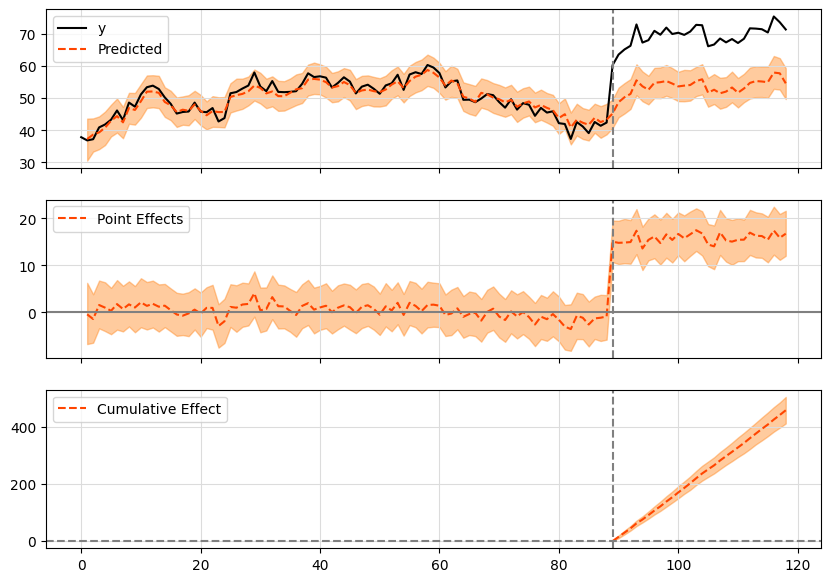

In [3]:
from causalimpact import CausalImpact

# CausalImpactを使用して学習・推定
ci = CausalImpact(
    data_df,
    [1, pre_period],
    [pre_period + 1, pre_period + post_period - 1],
)

# 結果の可視化
ci.plot()

#### Step 5 結果の評価

In [4]:
print(ci.summary())  # noqa: T201

"""
出力結果の説明
* Actual: 実際の処置後の平均値や累積値
* Prediction(s.d.): 処置がなかった場合の予測される平均値や累積値(標準偏差付き)
* 95% CI: 予測値の95%ベイズ信用区間

* Absolute effect (s.d.): 実測値と予測値との差(絶対効果)
* Relative effect (s.d.): Absolute effect(絶対効果)を実測値で割った値(相対効果)
"""

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    69.66              2020.15
Prediction (s.d.)         53.82 (0.77)       1560.77 (22.46)
95% CI                    [52.3, 55.34]      [1516.73, 1604.76]

Absolute effect (s.d.)    15.84 (0.77)       459.38 (22.46)
95% CI                    [14.32, 17.36]     [415.4, 503.42]

Relative effect (s.d.)    29.43% (1.44%)     29.43% (1.44%)
95% CI                    [26.61%, 32.25%]   [26.61%, 32.25%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


この分析によって、マーケティングキャンペーンの効果を次のように定量化できる

1. 販売数が平均で14.58個(28.94%)増加した
2. 95%信頼区間で、増加幅は12.47~16.4個(24.75%～32.54%)の間である
3. 累積効果として、1か月間で422.89個が追加販売された可能性がある

CausalImpactの結果の代表的な確認項目

1. 識別過程の確認

   * 分布シフトの確認: たとえば共変量シフトの場合、共変量をプロットし、処置前後で共変量が変化していないことを確認する
2. モデルの診断

   * モデルの適合度: 処置前のデータにモデルが適合していることを確認
   * 残差の分析: モデルの残差(実測値と予測値との差)をプロットして、ランダムなノイズであるかを確認
   * 残差の自己相関の確認: 残差の自己相関を調べることで、モデルが時系列の依存性を適切に捉えているかを確認
3. 信用区間の確認

   * 信用区間の幅: 信用区間が狭いほど、観測されていないパラメータ値(推定結果)がその狭い区間に収まる確率が高い
   * 信用区間と実測値: 処置後の実測値が信用区間内に収まっているかを確認。[7.4.2項](#742-causalimpactの実行手順)の例では実測値が予測値の信用区間内に入っていないため、因果効果がある可能性が高い
4. 感度分析

   * コントロール変数(処置変数以外の変数)の変更: 異なるコントロール変数を用いてモデルを再度実行し、結果がどの程度変わるかを確認
   * データ期間の変更: プラセボテストのように処置前後のデータ期間を変更して、結果が安定しているかを確認
5. バックテスト(過去に類似する処置がある場合)

   * 過去の処置でテスト: 過去に行われた、影響が既知の処置を用いてモデルをテスト
6. 外部要因やドメイン知識との照合

   * 外部要因の影響を確認: モデルに含まれていない外部要因が結果に影響を与えていないか確認
   * ドメイン知識との照合: 専門家の意見や他の研究と照らし合わせて、結果が妥当であるかを評価

### 7.4.3 CausalImpactの課題

CausalImpactの代表的な課題は以下のとおりです

1. 未観測の外部要因がある場合、結果に影響を与える可能性がある。簡単な例としては、季節性やトレンドを適切にモデルに組み込まれていないなど
2. CausalImpactでは、処置変数が共変量に影響を与えない仮定を置いている。もし処置変数が共変量に影響を与える場合には別途対応が必要

## 7.5 複数施策の効果検証

### 7.5.1 効果検証の落とし穴

例えば宣伝広告をすでに打っている既存の商品があって、その商品のバリエーションを発売して新たに宣伝を打ったときの効果検証が内包する問題

1. トレンドや季節性の要素を考慮できていない

* そもそもトレンドが増加/現象傾向ではないか?
* 時期的要因によって売上が変動した分を因果効果と混同していないか?

2. 同時期に他の施策が存在した場合に効果検証が適切にできない

   * 複数の施策を実施している場合、単体の施策の評価が難しい
3. 残存効果を考慮できていない

   * 施策の効果が長期間続く場合と、短期間で終わる場合があるので、考慮しないと過去と現在の違いを適切に比較できない
4. 競合の施策の影響を考慮できていない

   * 競合他社の施策が自社の施策に影響を与えていないか

これらの課題への対応策の一つとして、マーケティング・ミックスモデリング(Marketing Mix Modeling: MMM)がある

### 7.5.2 マーケティングミックスモデリング(MMM)の概要

* マーケティングにおいて、複数のメディアにおける施策の効果を算出するためのモデル(Media Mix Modelingとも呼ばれる)
* 施策にかけた費用のデータを用いて、mROI(Marketing Return On Investment)やROAS(Return on Advertising Spend)の算出ができるため、最適な予算配分のための指標として活用可能
* 線形回帰モデルを用い、各メディアの効果を係数として算出する

$$
\underbrace{Y_t}_{売上}
= \underbrace{\alpha}_{切片}
+ \underbrace{\sum_{m=1}^M \beta_m f_m (T_{t, m})}_{各メディアの売上への影響}
+ \underbrace{\sum_{i=1}^N \gamma_iX_{t,i}}_{メディア以外の売上への影響}
+ \underbrace{trend_t}_{トレンド項}
+ \underbrace{seasonality_t}_{季節項}
+ \underbrace{\varepsilon_t}_{誤差項}
$$

* $Y_t$: 時点$t$の売上高
* $\alpha$: 切片
* $\beta_m$: メディア固有の係数
* $f_m$: メディアの影響を変換するための関数(詳細後述)
* $T_{t, m}$: 時点$t$におけるメディア変数(インプレッション、クリック、費用など)
* $\gamma_i$: コントロール変数の係数(処置変数以外の共変量固有の係数)
* $X_{t, i}$: 時間$t$におけるコントロール変数(処置変数以外の共変量)
* $trend_t$: トレンド項
* $seasonality_t$: 季節項
* $\varepsilon_t$: 誤差項

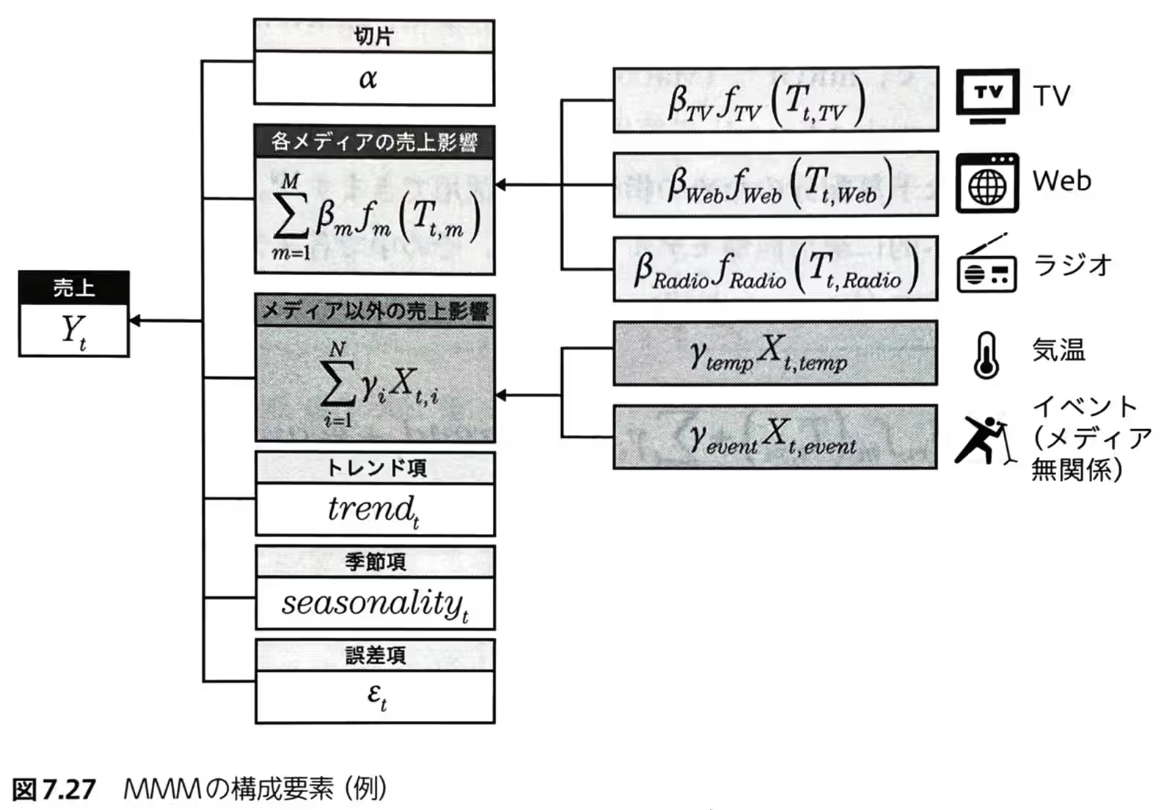

$f_m$には、1.形状効果(Shape Effect)と、2.アドストック効果(Adstock Effect)が含まれている

|              | 形状効果(Shape Effect)                                                                                                                 | アドストック効果(Adstock Effect)                                                                        |
| ------------ | -------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
| 目的         | メディアの応答曲線の「形」を捉え、コストや施策の回数などと反応の関係を表す                                                             | メディアの効果が時間をかけて続く状況を捉える                                                            |
| 使用する関数 | ・凹曲線の場合: 指数関数(特に↓を使用した関数)`<br>`・S字曲線の場合: Hill関数などの形状をモデル化する関数                            | アドストック関数などの時間に依存する関数                                                                |
| 主な特徴     | Hill関数の場合 `<br>`・飽和効果: 効果が一定値以上に増加しない状況を表す `<br>`・形状パラメータ: 効果がどれだけ急激に変わるかを表す | ・減衰効果: メディアの効果が徐々に減少する状況を表す `<br>`・遅延効果: 効果がすぐに現れない状況を表す |
| 活用例       | 各メディアの効果の形状を理解し、飽和するポイントを見つけ、施策を計画する                                                               | 各メディアの効果がどれだけの時間持続するかを理解し、施策を計画する                                      |

1. 形状効果
   メディアの応答曲線の傾きや飽和などの形を捉える。どが考慮されます。
   形状効果の表現方法としてはいくつかありますが、有名なものとしてHIllのモ
   1910）があります（式（7-9））。このモデルでは、パラメータを設定し、
   効果の最大値と減衰係数を推定することで、残存効果を表現します。

$$
Hill\left(T_{t, m};K_m, S_m\right)
= \frac{1}{1 + \left(\frac{T_{t, m}}{K_m}\right)^{-S_m}},
\ T_{t,m}\geq0
$$

ここで、メディア毎の単位あたり売上への影響の違い$\beta_m$を導入すると、以下のように式変形できる

$$
\beta_m Hill(T_{t,m}) 
= \beta_m
- \frac{K_m^{S_{m}} \beta_m}
       {T_{t, m}^{S_{m}} + K_m^{S_{m}}}
$$

* $S_m$: 形状パラメータ(傾き)
* $K_m$: 半飽和点(half saturation point)。メディアの効果が半分まで達する点
* $T_m$: 処置変数
* $\beta_m$:各メディアの単位当たり売上影響

2. アドストック効果
   メディアが与える影響の持続期間を考慮した効果。広告を見た後に、すぐ商品を買いに行く人、間を空けて商品を買いに行く人など。
   この効果を数学的に表す式の一つに、アドストック関数がある。特にキャリーオーバー効果と呼ばれるものを表した式を示す。

   $$
   adstock(T_{t-L+1, m}, \ldots, T_{t,m};w_m, L)
   = \frac{\sum_{l=0}^{L-1} w_m(l) T_{t-l, m}}
          {\sum_{l=0}^{L-1} w_m(l)}
   $$

   $$
   w_m^d(l; \,\alpha_n, \theta_m)
   = \alpha_m^{(l-\theta_m)^2},
   \;\; l = 0, \ldots, L - 1,
   \;\; 0 \lt \alpha_m \lt 1,
   \;\; 0 \leq \theta_m \leq L-1
   $$

* $L$: メディア$m$に対して仮定したキャリーオーバー効果の最大持続期間。Lはメディア別に異なるが、上式では単純化のために共通のLを使用
* $w_m$: メディアの重み関数。ここでは減衰効果(Geometric decay、幾何学的減衰)と遅延効果(Delayed adstock、遅延アドストック)を表した以下の重み関数$w_m^d$を使用
  * 減衰効果(幾何学的減衰)

    時間の経過とともに、メディアの効果が小さくなること
  * 遅延効果(遅延アドストック)
    メディアの効果が時間差で現れること
* $\alpha_m$: 減衰パラメータ
* $\theta_m$: 減衰の遅延パラメータ(遅延効果を表す)

形状効果や、アドストック効果の表現は柔軟に変更可能。ドメイン知識にあわせて調整すること。これらをMMMの関数$f_m$に導入すると以下の式となる

$$
Y_t
= \alpha
+ \sum_{m=1}^M \beta_m Hill(T_{t, m}^*; K_m, S_m)
+ \sum_{i=1}^N \gamma_i X_{t, i}
+ trend_t + seasonality_t + \varepsilon_t \\
T_{t, m}^* = adstock(T_{t-L+1, m}, \ldots, T_{t, m}; w_m,L)
$$

* 競合効果

必要であれば競合効果もモデルに含める

競合効果: 競合他社の施策データを同じようにモデル化し、その係数は、自社に負の影響を与えるとしてすべて負($\lt 0$)とする

すべての効果を含めた式は以下になる

$$
\begin{align}
Y_t
= \alpha
&+ \sum_{m=1}^M \beta_m Hill(T_{t, m}^*; K_m, S_m)
 + \sum_{i=1}^N \gamma_i X_{t, i}
 + trend_t + seasonality_t \nonumber \\
&+ \sum_{j=1}^P \delta_j g(W_{t, j})
 + \varepsilon_t \nonumber
\end{align}
$$

$\delta_j$: 競合メディア固有の係数($\lt 0$として設定)
$W_{t, j}$：時点$t$における競合メディア変数(インプレッション、クリック、費用など)
$g$: 競合メディアの影響を変換するための関数

さらに、MMMでは分析結果を基に予算を増減させたときのメディアミックスの最適化も可能

### 7.5.3 MMMの実行手順

問題設定: これまで使用してきたメディアの見直しのために効果検証を行う。TV、Webのそれぞれの広告費用体効果(ROAS)はどれほどか?

[pymc-marketingのサンプルノートブック](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)を参照

#### Step 1 ライブラリの準備、データの確認


In [1]:
# jupyterの設定変更
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import warnings  # Pythonでの警告メッセージを制御するためのライブラリ

import arviz as az  # 統計モデルの診断と可視化のためのライブラリ
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # Pythonの警告メッセージを表示しないように設定.
az.style.use("arviz-darkgrid")  # arvizのデフォルトスタイルを "arviz-darkgrid"に設定
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100


In [3]:
# データ生成
import numpy as np
import pandas as pd
import pymc as pm  # ベイズモデリングのためのライブラリ

# 乱数生成器を初期化
rng = np.random.default_rng(seed=1)

# データの期間(週次データを使用).
min_date = pd.to_datetime("2020-04-01")
max_date = pd.to_datetime("2023-09-01")

# 指定された期間の週次データを含むデータフレームを作成し、年、月、日の情報を追加
df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")  # noqa: T201


Number of observations: 178


Text(0.5, 0.98, 'Media Costs Data')

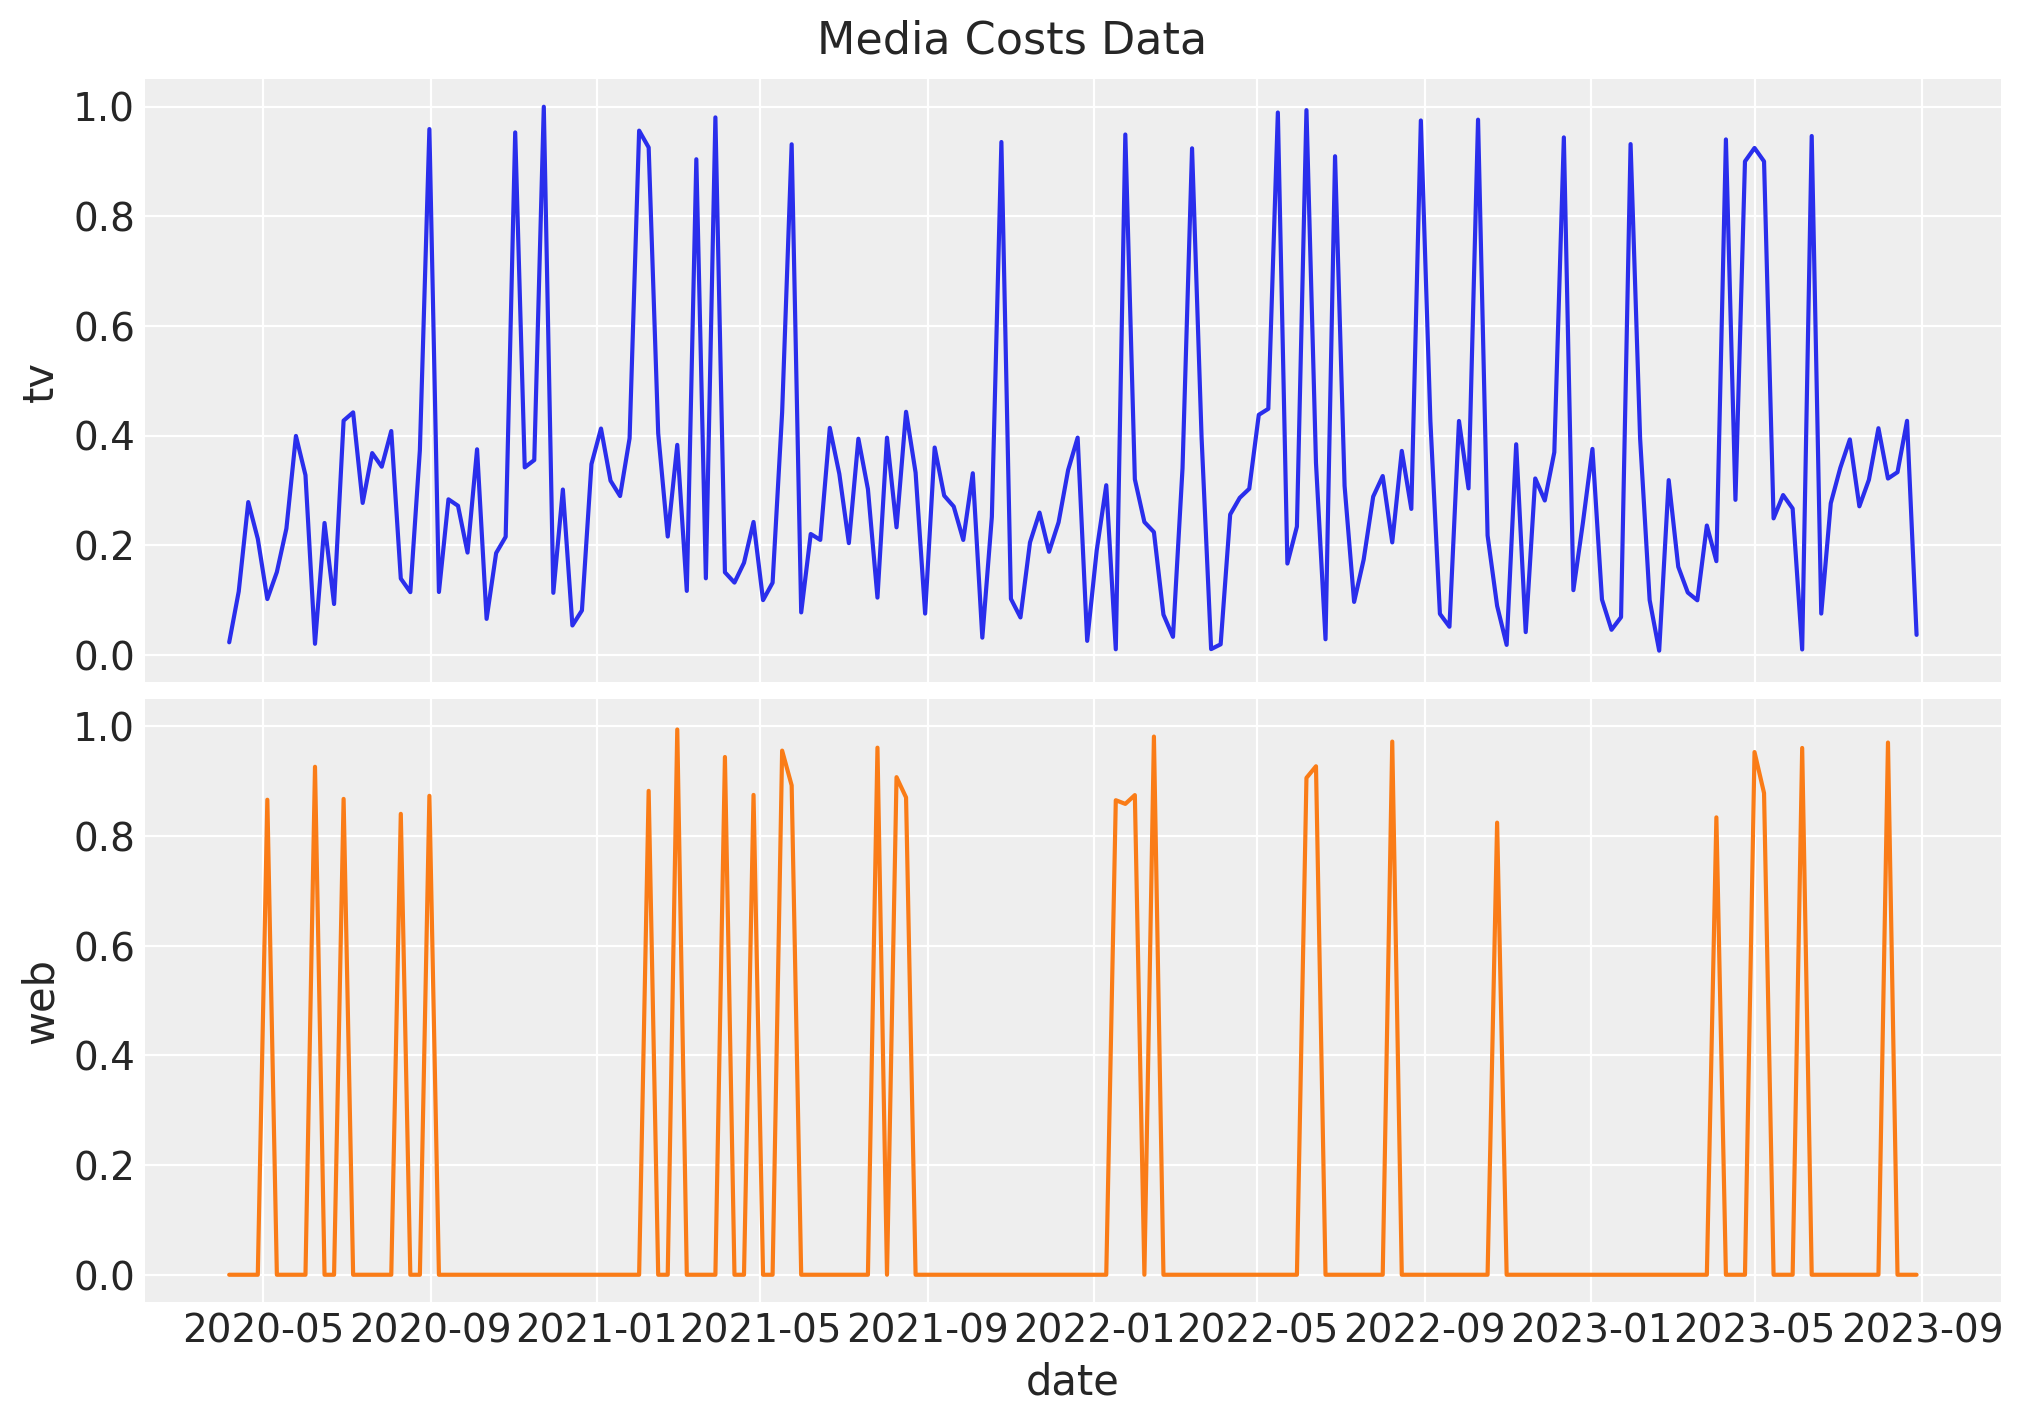

In [7]:
import seaborn as sns

# 一様分布からランダムなTVデータを生成
tv = rng.uniform(low=0.0, high=1.0, size=n)
# TVの広告費データをデータフレームに追加し、一定の条件に基づいて値を変更
df["tv"] = np.where(tv > 0.9, tv, tv / 2)
# 同様に、一様分布からランダムなWebの広告費データを生成
web = rng.uniform(low=0.0, high=1.0, size=n)
# Webデータをデータフレームに追加し、一定の条件に基づいて値を変更
df["web"] = np.where(web > 0.8, web, 0)

# 一旦データを可視化して確認
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="tv", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="web", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16)

In [8]:
# 幾何学的アドストック関数とロジスティック飽和関数をインポート
from pymc_marketing.mmm.transformers import (
    geometric_adstock,
    logistic_saturation,
)

# アドストック用のパラメータを設定
alpha1: float = 0.4
alpha2: float = 0.2

# TVとWebデータに対してアドストック効果に基づく変換を適用
df["tv_adstock"] = (
    geometric_adstock(x=df["tv"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)
df["web_adstock"] = (
    geometric_adstock(x=df["web"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

Text(0.5, 0.98, 'Media Costs Data - Transformed')

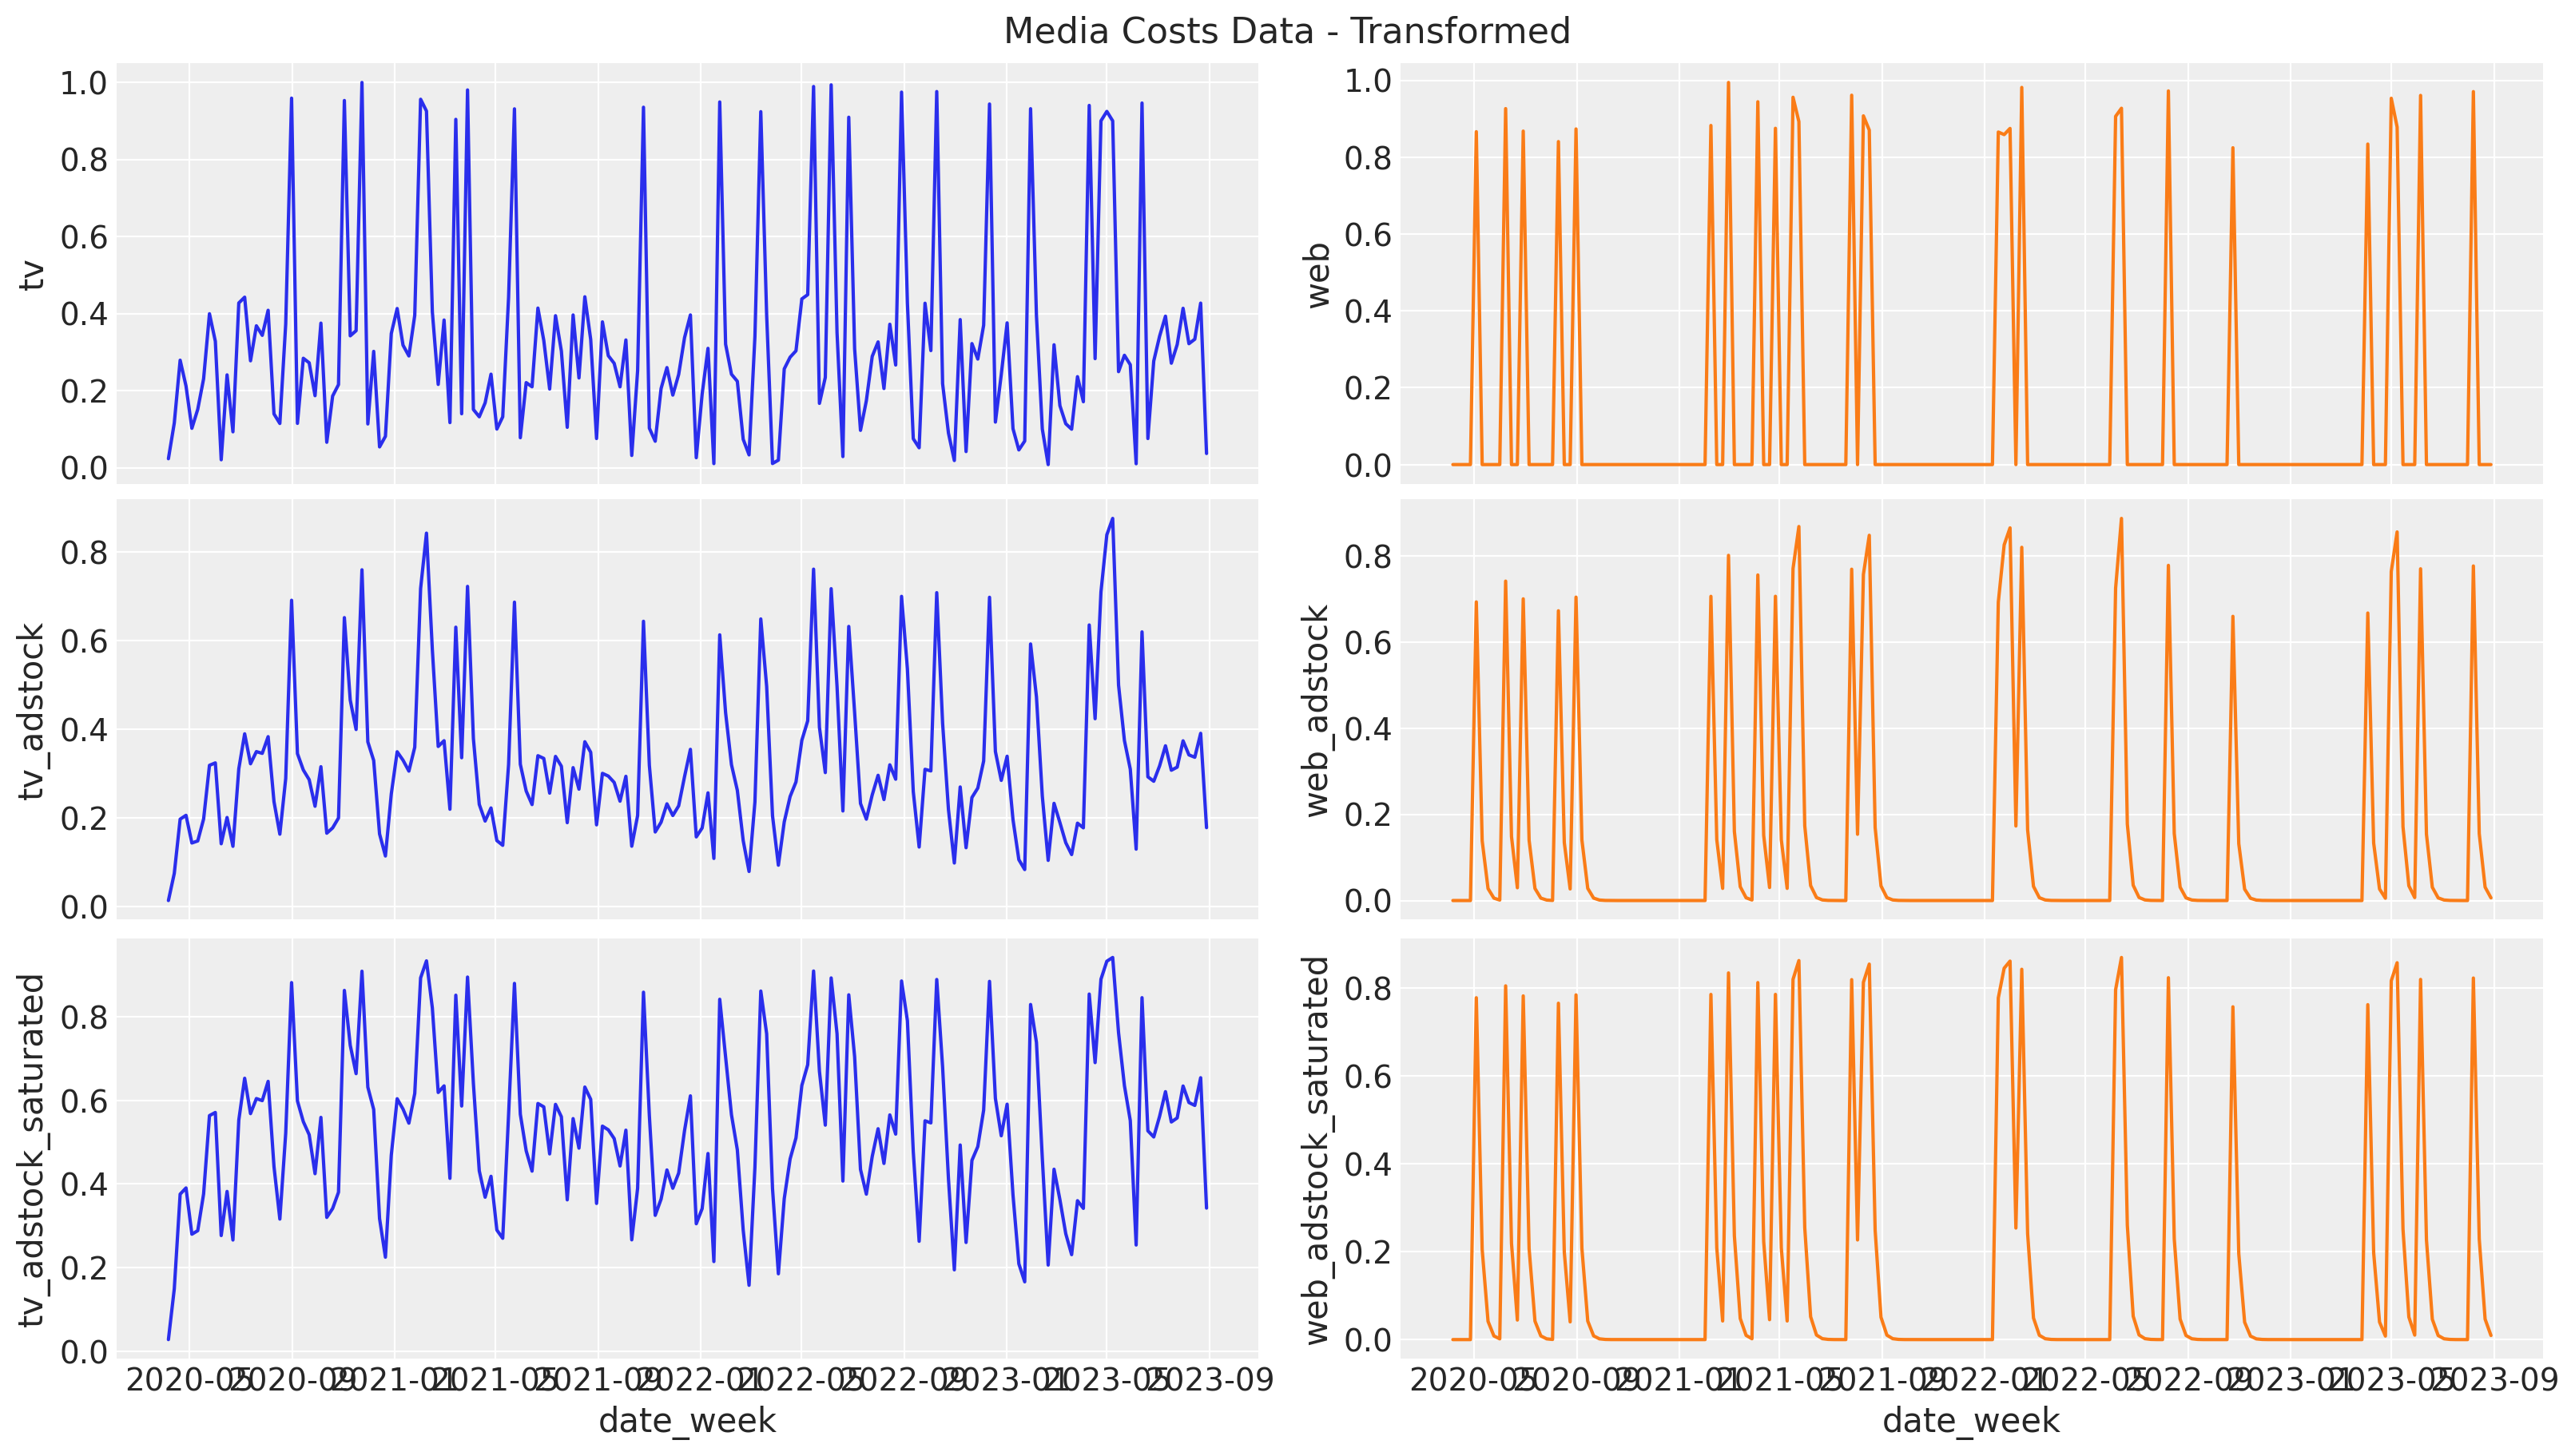

In [10]:
# 形状パラメータを設定
lam1: float = 4.0
lam2: float = 3.0

# TVとWebのアドストックデータに対して形状効果に基づく変換を適用
df["tv_adstock_saturated"] = logistic_saturation(
    x=df["tv_adstock"].to_numpy(), lam=lam1
).eval()
df["web_adstock_saturated"] = logistic_saturation(
    x=df["web_adstock"].to_numpy(), lam=lam2
).eval()

# ここまでのデータを可視化
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="tv", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="web", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="tv_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="web_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="tv_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="web_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16)

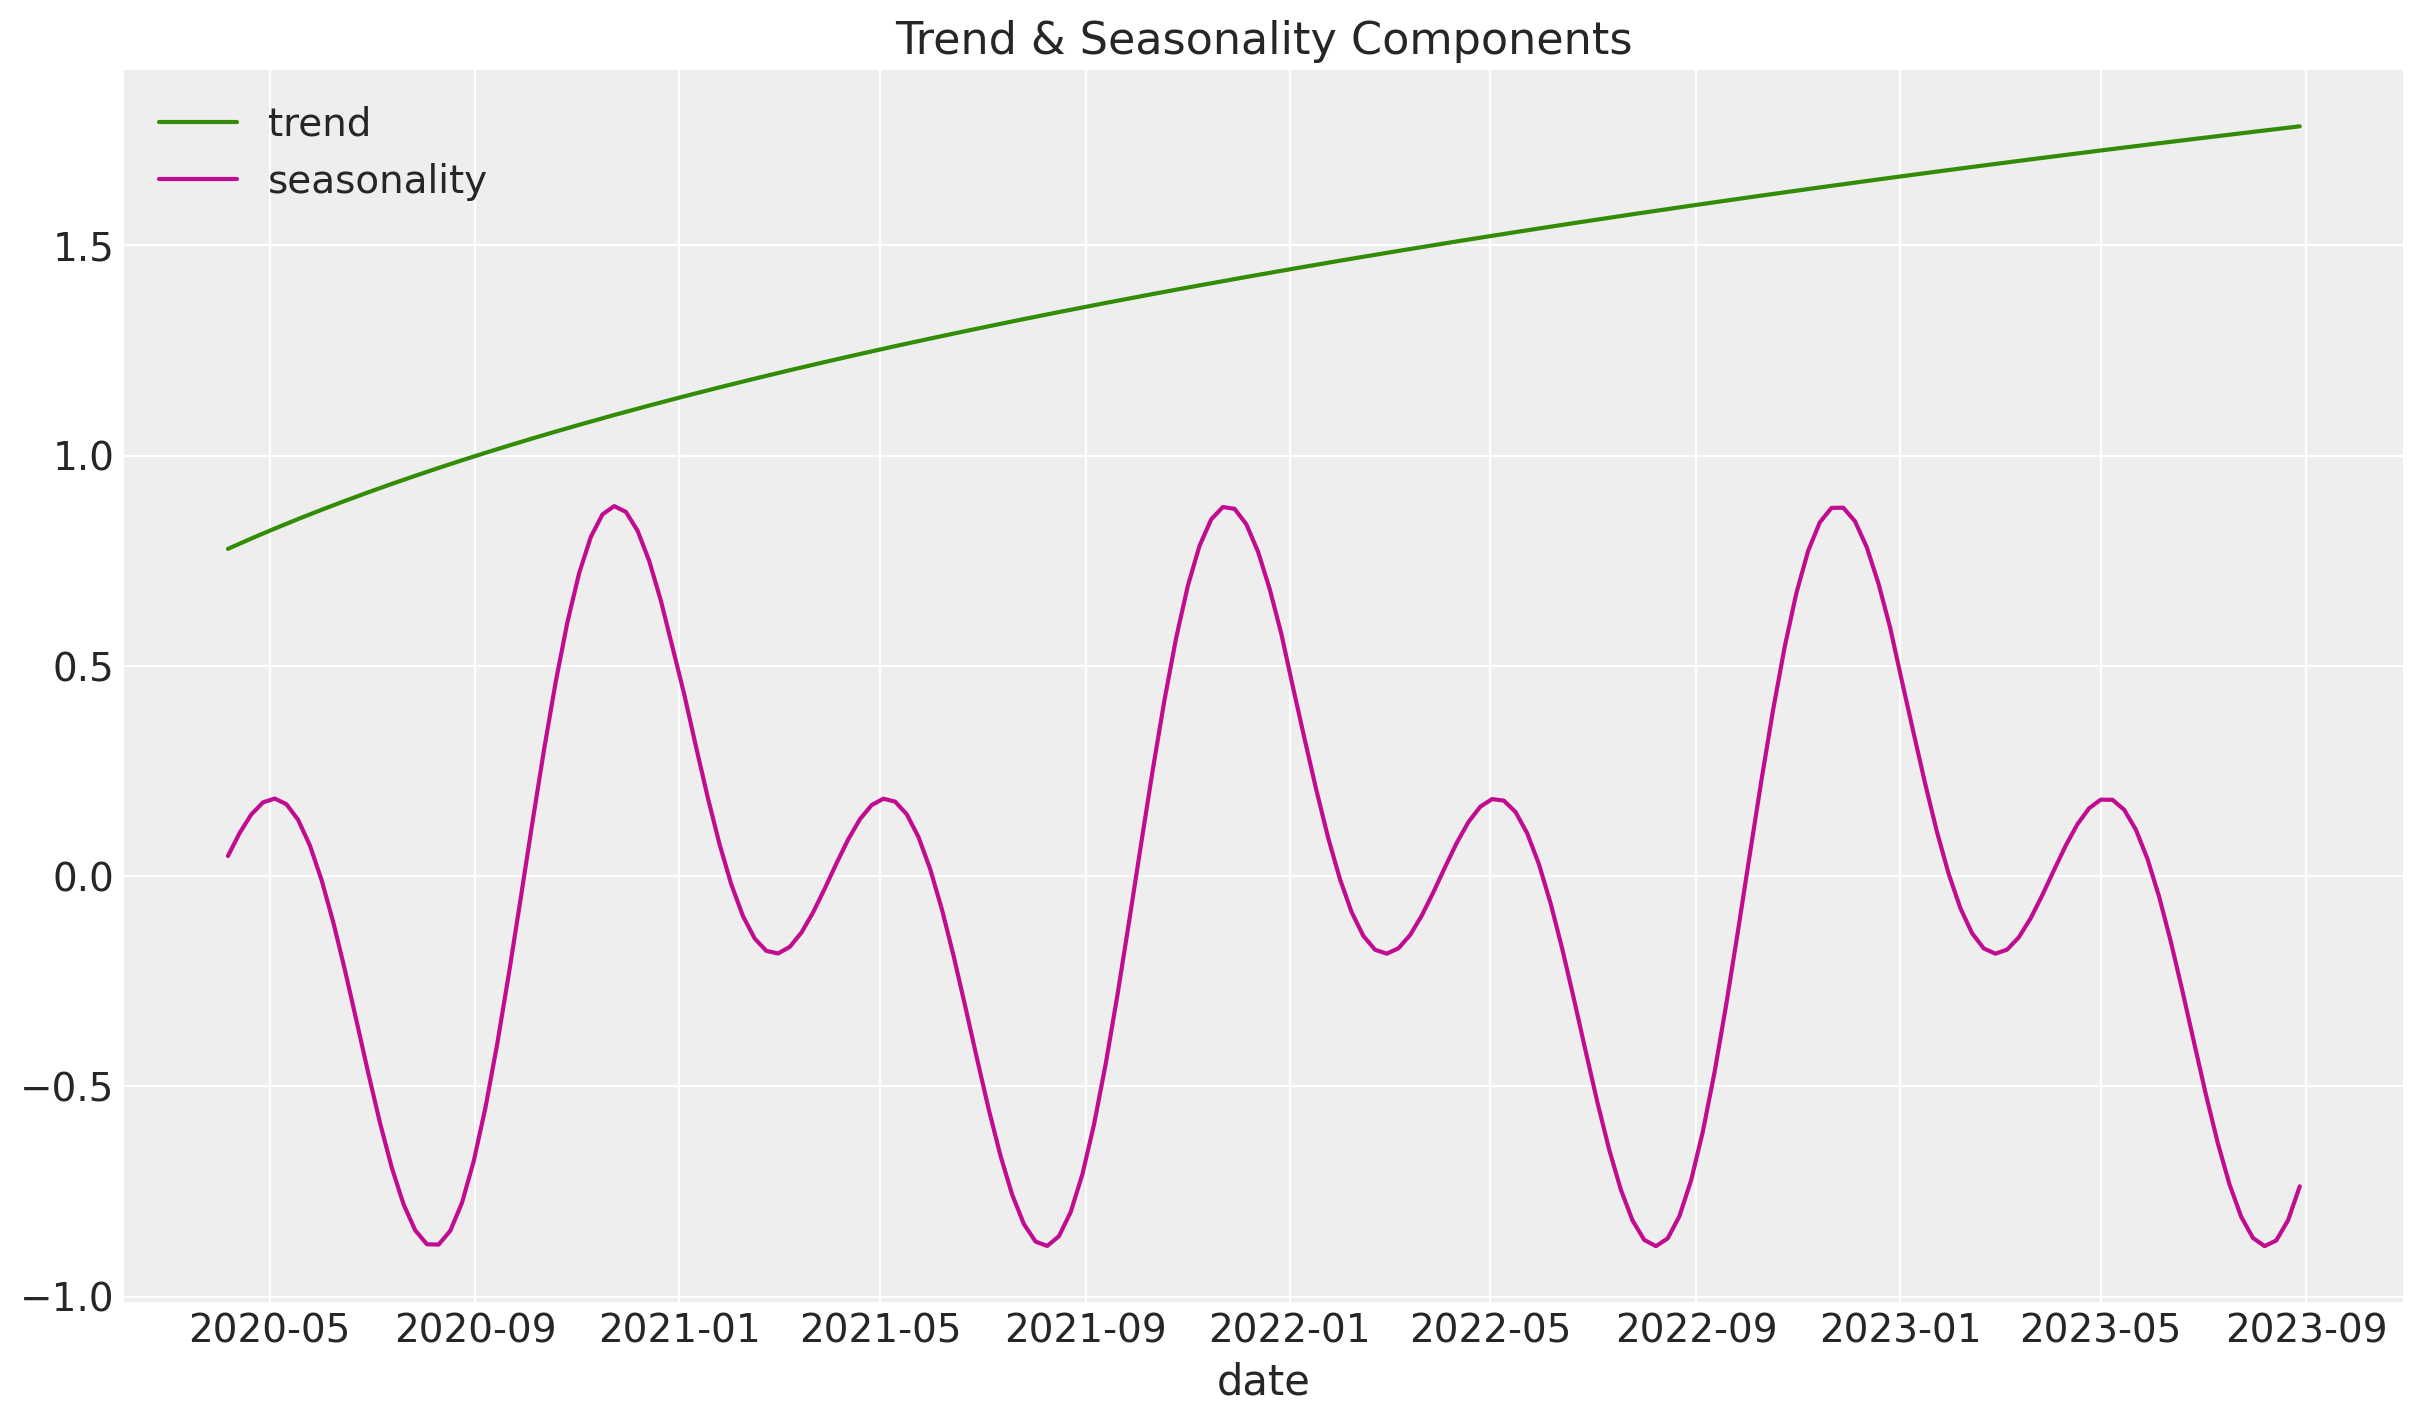

In [12]:
# トレンド項と季節項を追加

# トレンド項をデータフレームに追加
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

# 季節項の計算を行い、データフレームに追加
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])  # 季節項

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

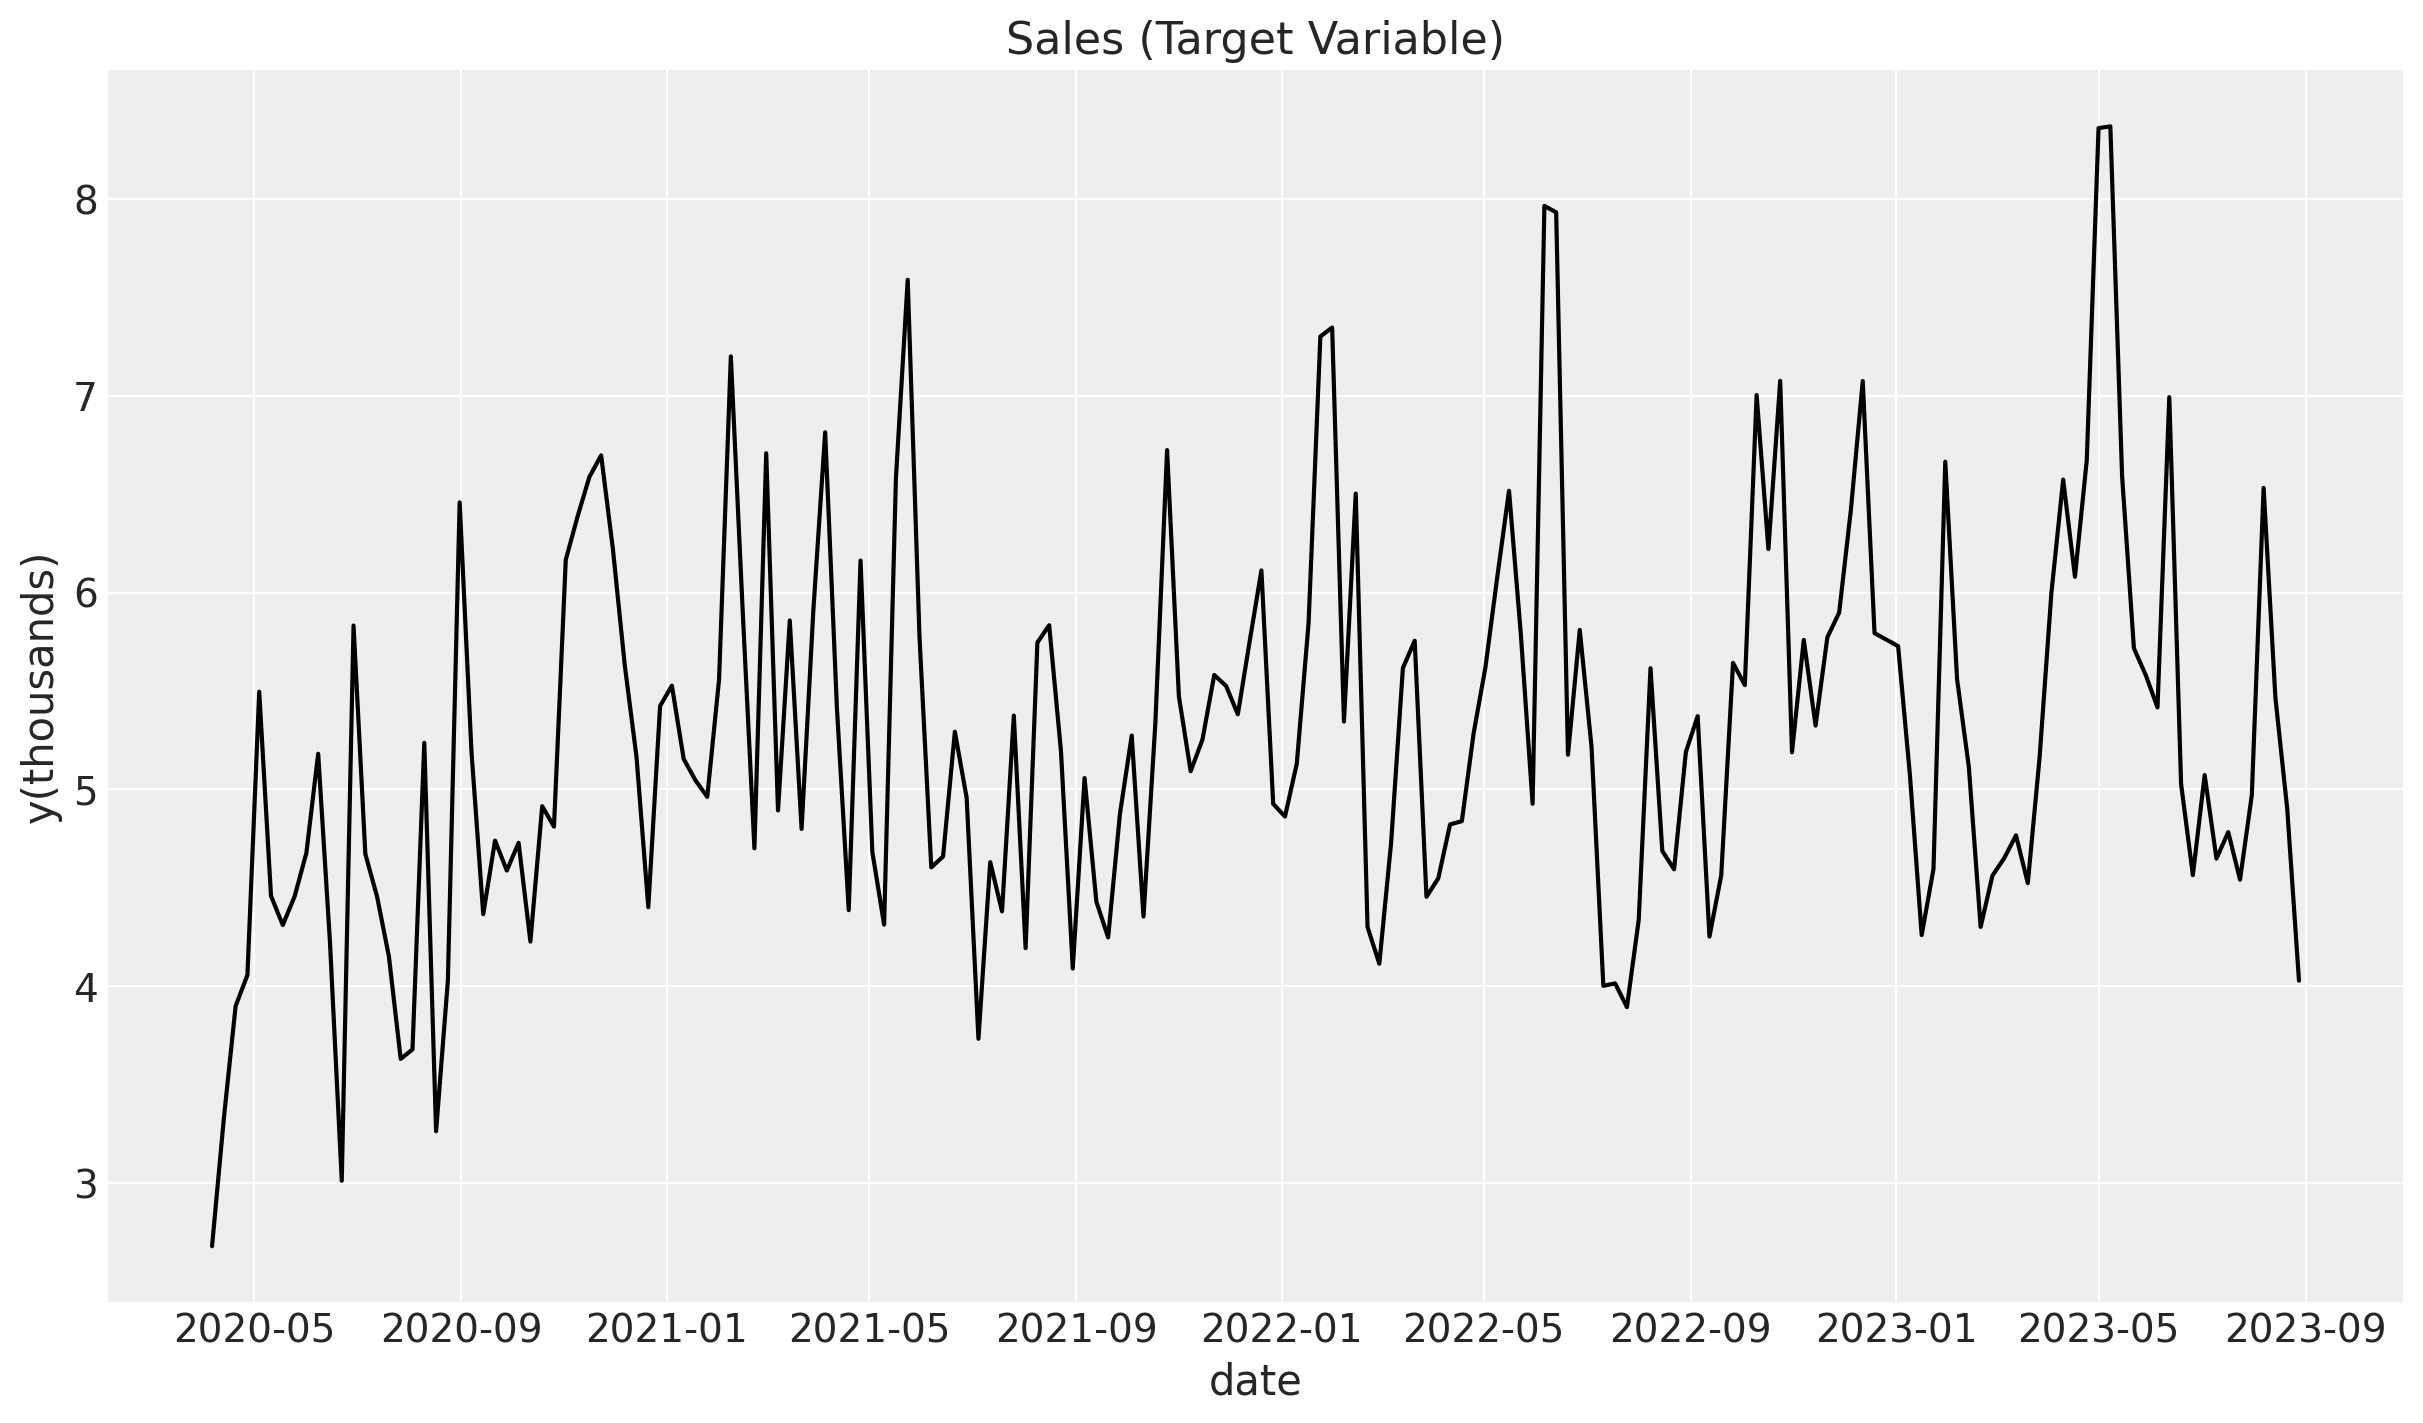

In [17]:
# 制御変数
# イベント項、切片、誤差項をデータフレームに追加
df["event_1"] = (df["date_week"] == "2021-05-13").astype(float)  # イベント項①
df["event_2"] = (df["date_week"] == "2022-09-14").astype(float)  # イベント項②

# ターゲット変数(売上).
df["intercept"] = 2.0  # 切片
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)  # 誤差項

# TVとWebの効果の係数をサンプルデータ生成のために設定
amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]

# 売上データの生成
df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["tv_adstock_saturated"]
    + beta_2 * df["web_adstock_saturated"]
    + df["epsilon"]
)

# 売上データの可視化
fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y(thousands)");

[Text(0.5, 1.0, 'Sales Attribution'), Text(0, 0.5, 'Sales (thousands)')]

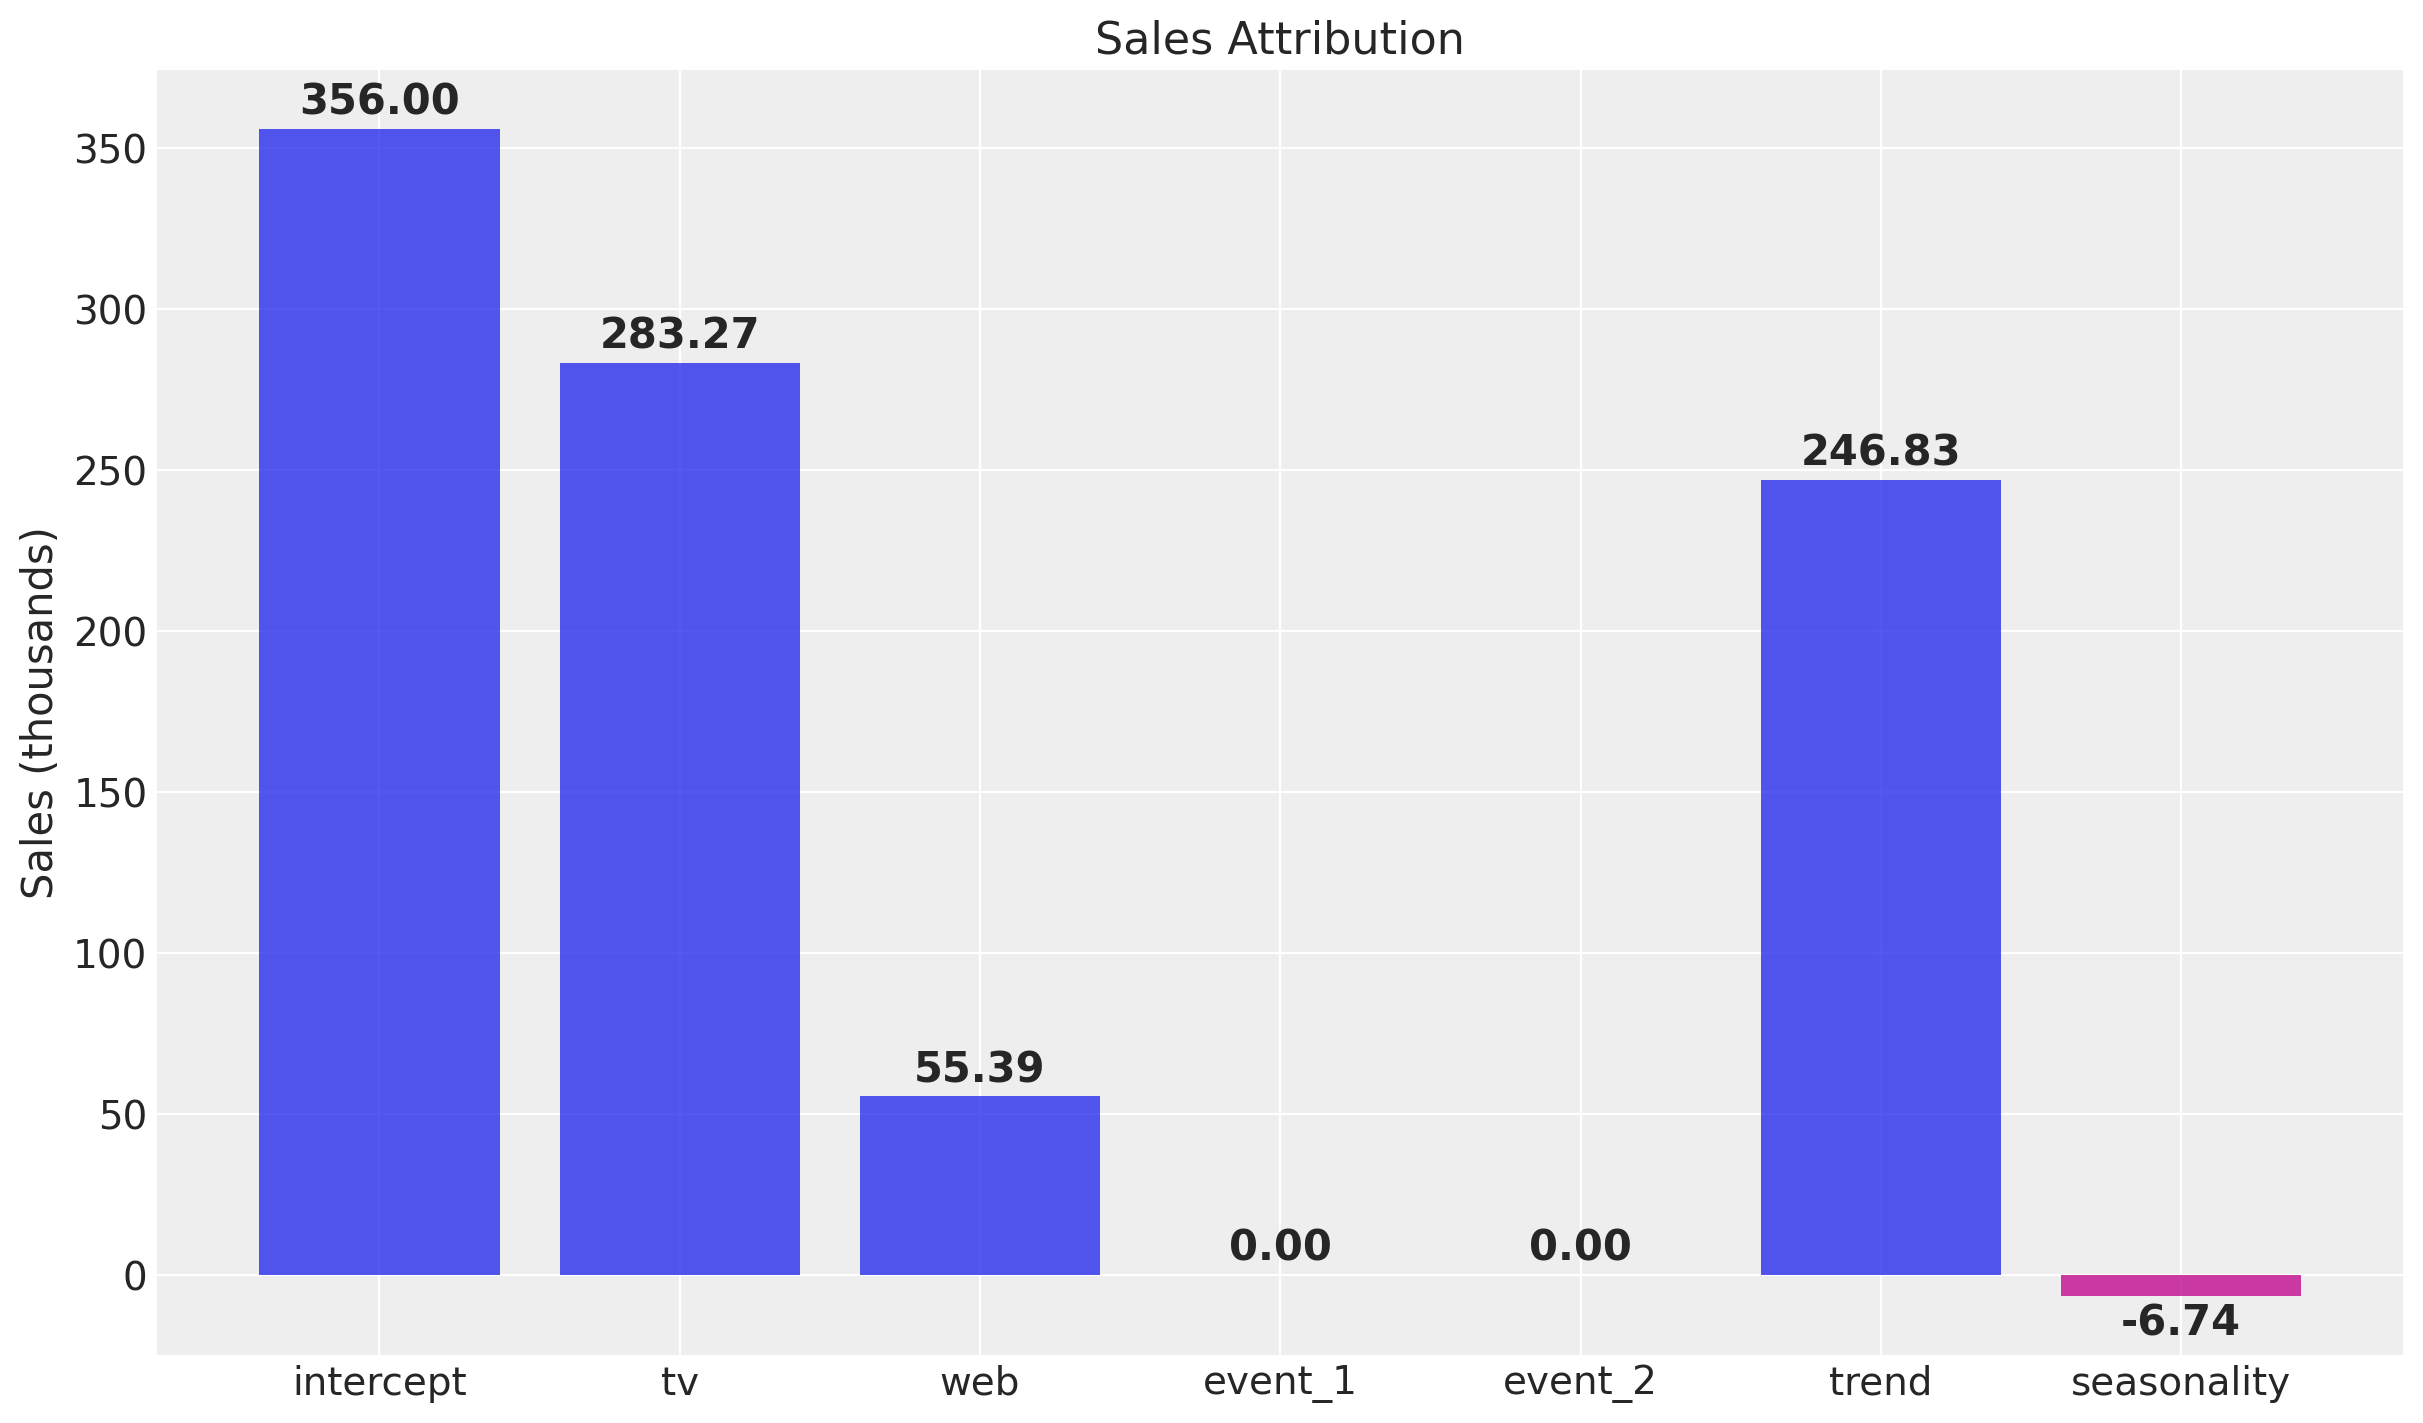

In [18]:
# 各項目の寄与度を可視化
fig, ax = plt.subplots()

contributions = [
    df["intercept"].sum(),
    (beta_1 * df["tv_adstock_saturated"]).sum(),
    (beta_2 * df["web_adstock_saturated"]).sum(),
    1.5 * df["event_1"].sum(),
    2.5 * df["event_2"].sum(),
    df["trend"].sum(),
    df["seasonality"].sum(),
]

ax.bar(
    ["intercept", "tv", "web", "event_1", "event_2", "trend", "seasonality"],
    contributions,
    color=["C0" if x >= 0 else "C3" for x in contributions],
    alpha=0.8,
)
ax.bar_label(
    ax.containers[0],
    fmt="{:,.2f}",
    label_type="edge",
    padding=2,
    fontsize=15,
    fontweight="bold",
)
ax.set(title="Sales Attribution", ylabel="Sales (thousands)")

In [19]:
# メディアの寄与度
contribution_share_tv: float = (beta_1 * df["tv_adstock_saturated"]).sum() / (
    beta_1 * df["tv_adstock_saturated"] + beta_2 * df["web_adstock_saturated"]
).sum()
contribution_share_web: float = (beta_2 * df["web_adstock_saturated"]).sum() / (
    beta_1 * df["tv_adstock_saturated"] + beta_2 * df["web_adstock_saturated"]
).sum()
print(f"Contribution Share of tv: {contribution_share_tv:.2f}")  # noqa: T201
print(f"Contribution Share of web: {contribution_share_web:.2f}")  # noqa: T201


Contribution Share of tv: 0.84
Contribution Share of web: 0.16


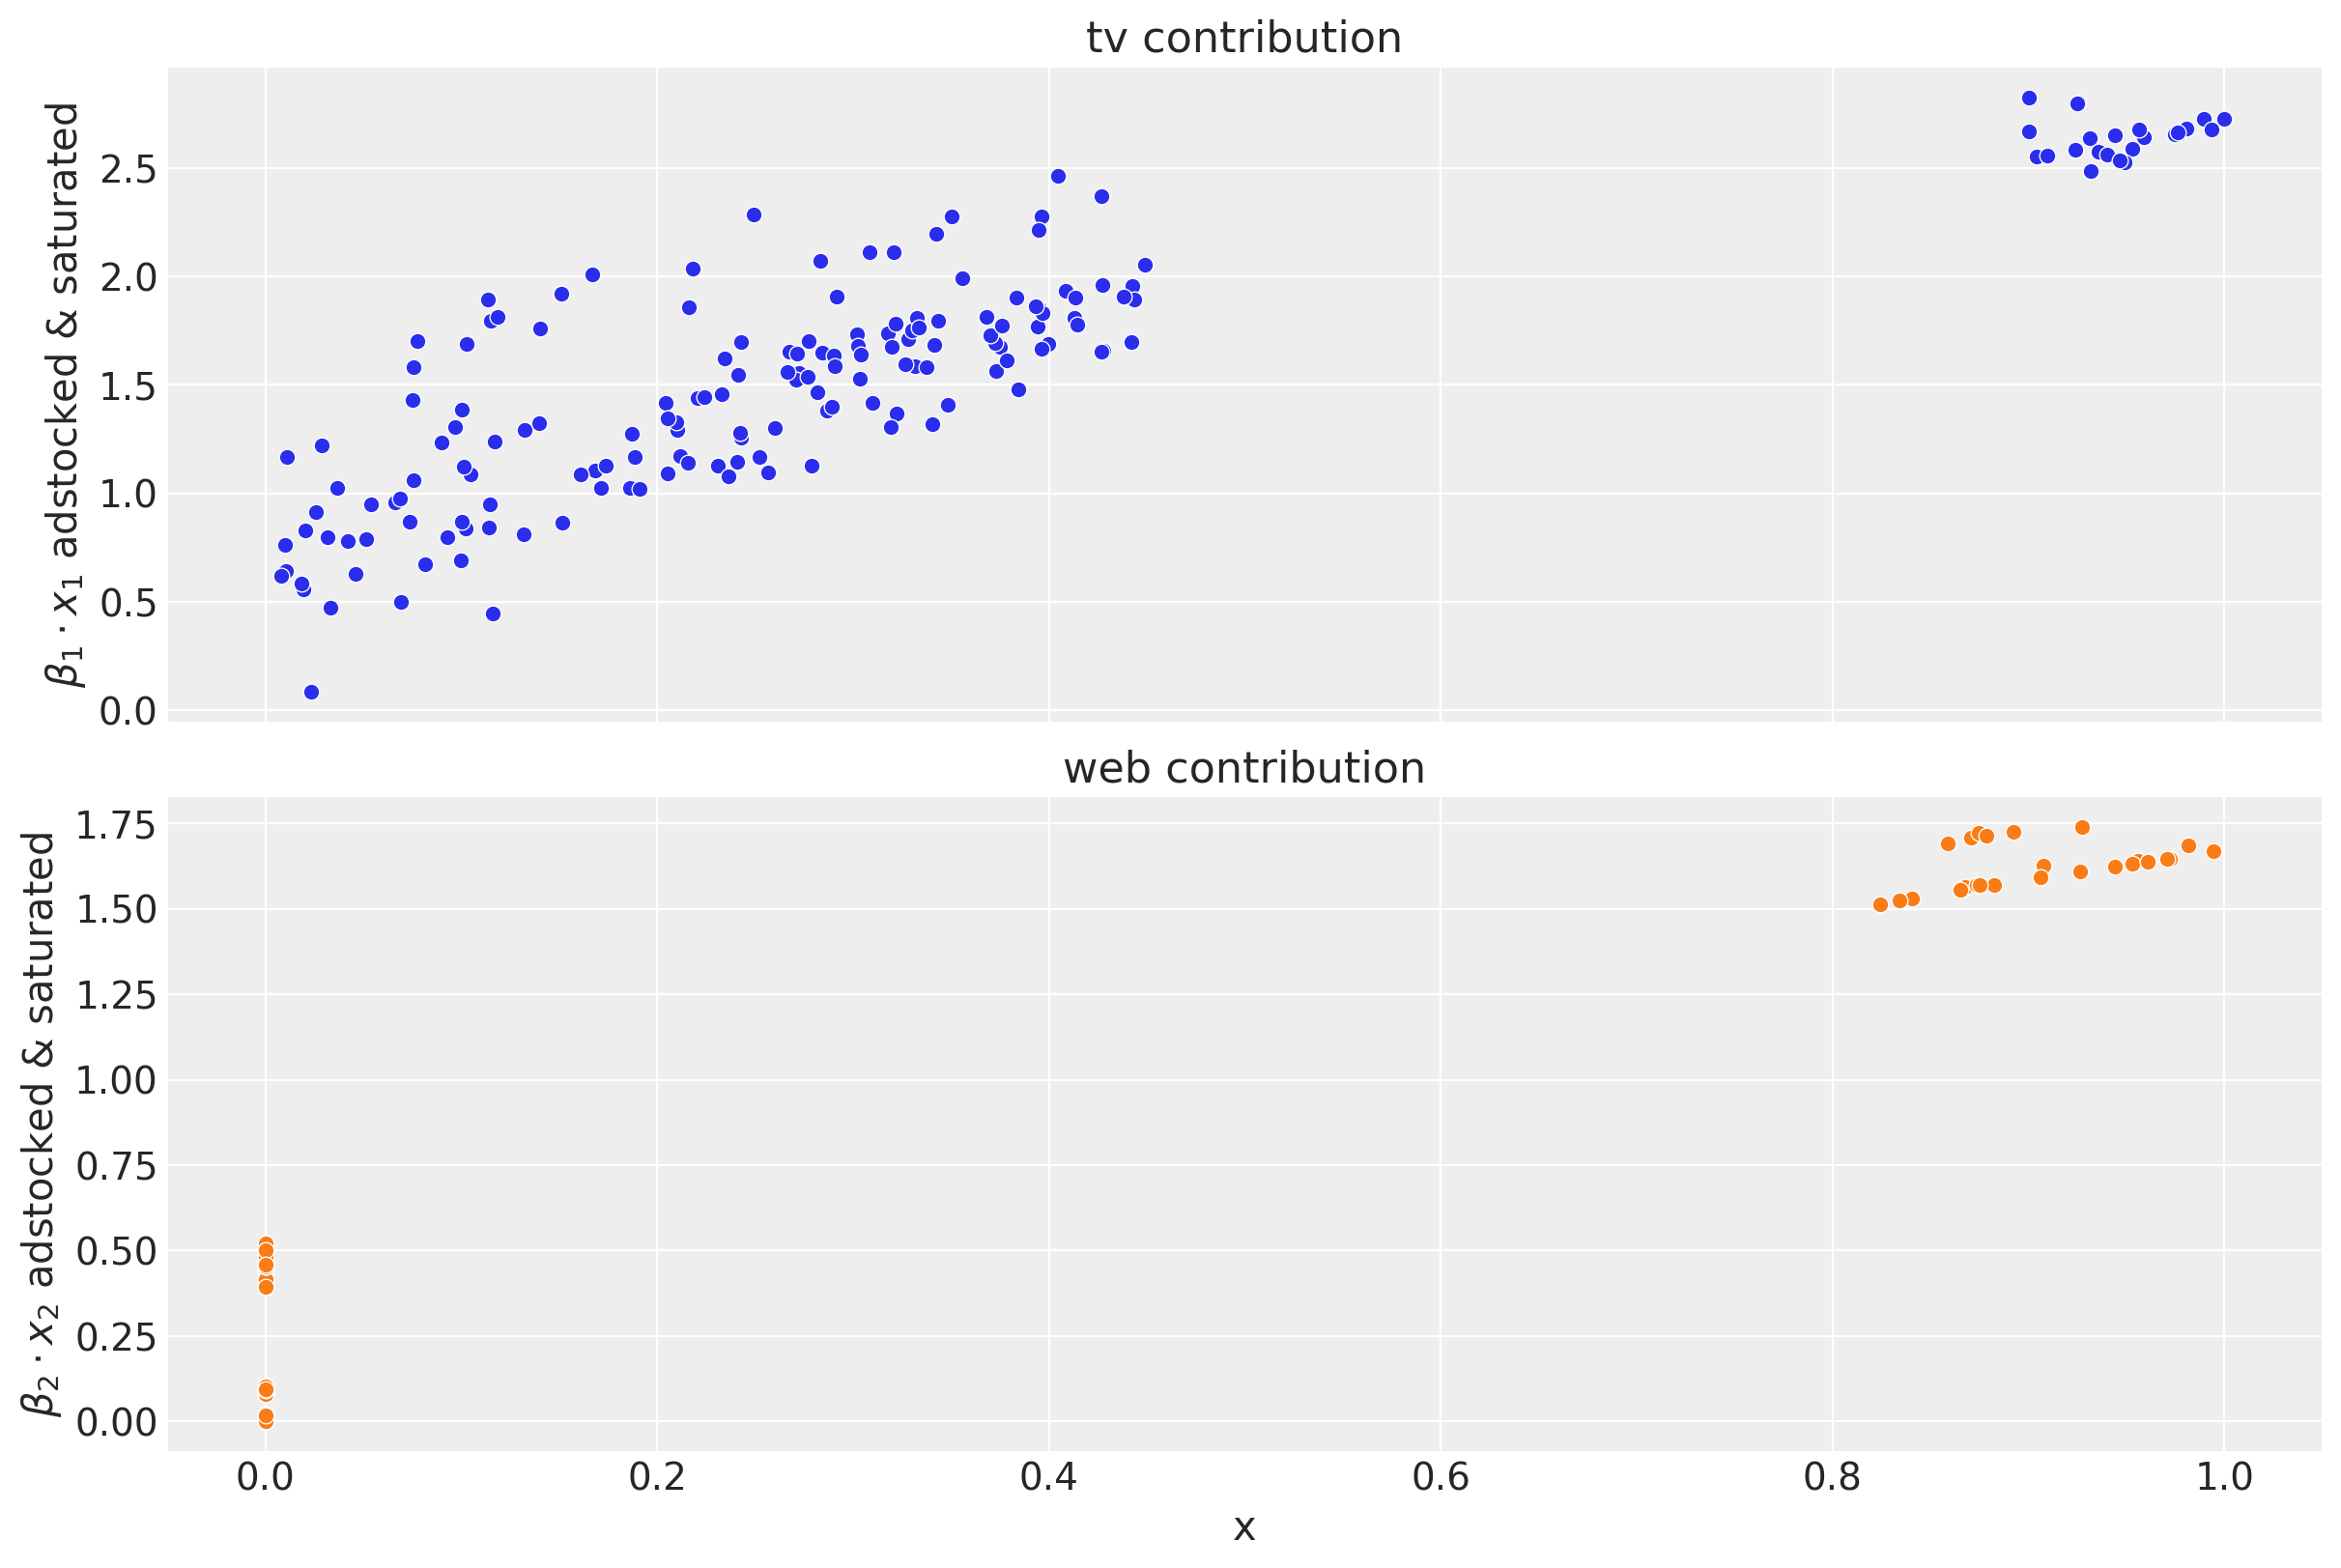

In [22]:
# 各チャネルの寄与度を可視化
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 8),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, x in enumerate(["tv", "web"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"{x} contribution",
        ylabel=f"$\\beta_{i + 1} \\cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

Roas of tv: 4.88
Roas of web: 2.26


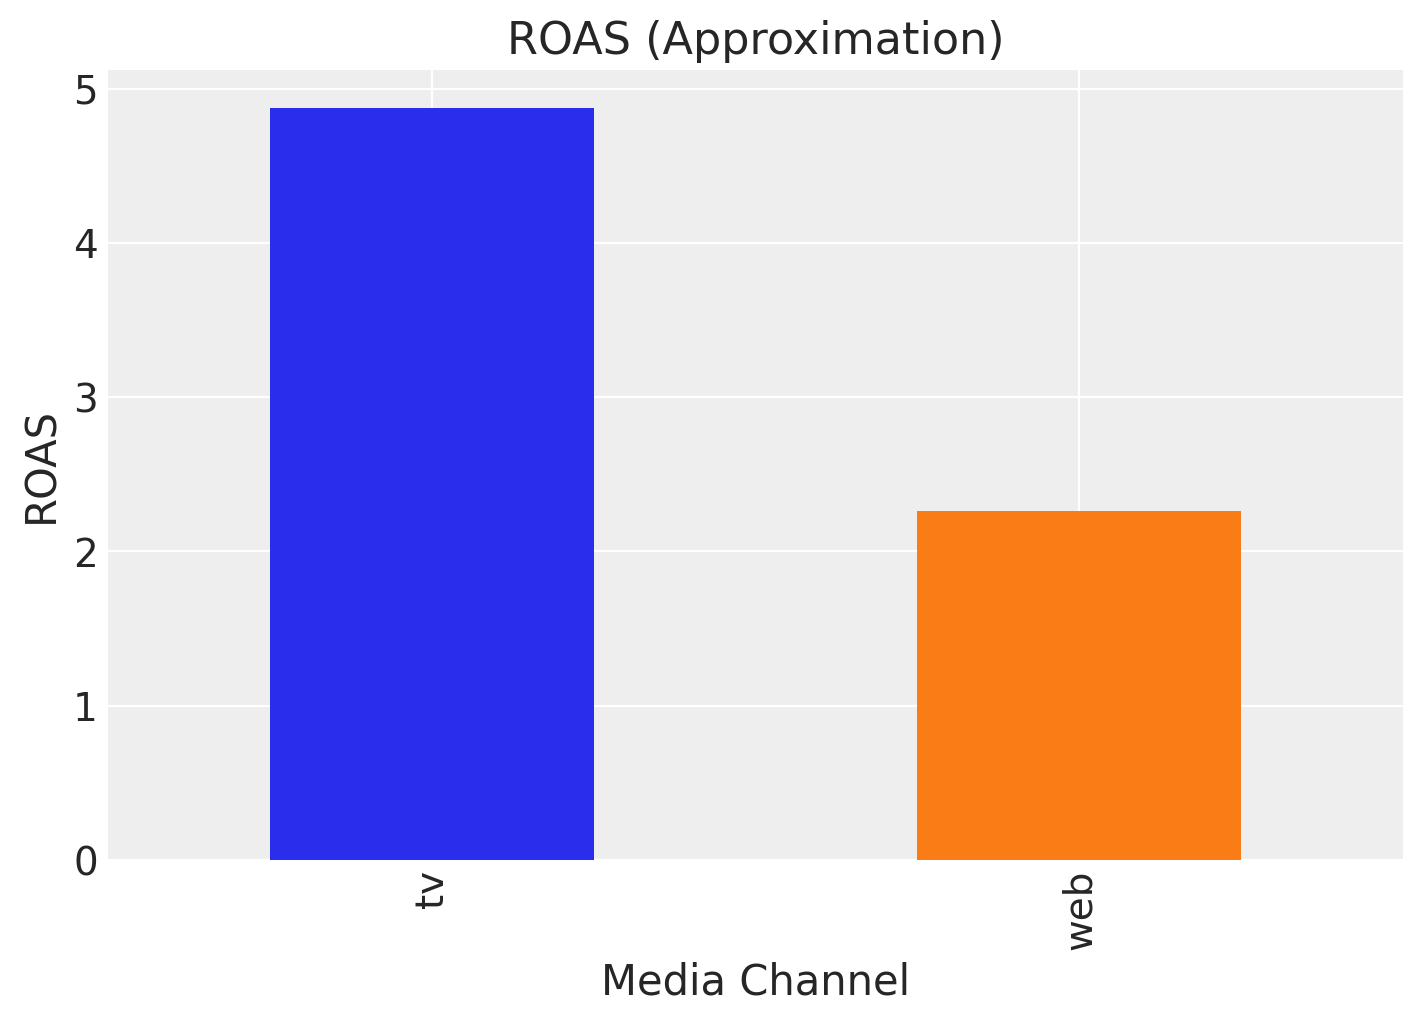

In [25]:
# ROASの確認
roas_tv = (beta_1 * df["tv_adstock_saturated"]).sum() / df["tv"].sum()
roas_web = (beta_2 * df["web_adstock_saturated"]).sum() / df["web"].sum()
print(f"Roas of tv: {roas_tv:.2f}")  # noqa: T201
print(f"Roas of web: {roas_web:.2f}")  # noqa: T201

fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_tv, roas_web], index=["tv", "web"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [27]:
# モデリングしていく

columns_to_keep = [
    "date_week",
    "y",
    "tv",
    "web",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
data["t"] = range(n)  # 番号の設定(後でトレンド項として使用)
data.head()

date_week         y        tv       web  event_1  event_2  dayofyear  t
0 2020-04-06  2.680536  0.023170  0.000000      0.0      0.0         97  0
1 2020-04-13  3.329544  0.115881  0.000000      0.0      0.0        104  1
2 2020-04-20  3.900338  0.278841  0.000000      0.0      0.0        111  2
3 2020-04-27  4.057456  0.211840  0.000000      0.0      0.0        118  3
4 2020-05-04  5.496460  0.102049  0.866241      0.0      0.0        125  4

In [29]:
total_spend_per_channel = data[["tv", "web"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()
spend_share

tv     0.703719
web    0.296281
dtype: float64

In [31]:
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)
n_channels = 2  # チャネル数
# 事前分布の標準偏差
prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()
prior_sigma.tolist()

[2.3347927444730012, 0.9830007354676108]

In [32]:
X = data.drop("y", axis=1)
y = data["y"]

#### Step 2 DAGの確認

![図7.32](images/chap7/image-7.png)

#### Step 3 識別仮定の確認

基本的には[7.4.2項](#742-causalimpactの実行手順)と同じだが、処置変数と共変量の数が多いのですべての処置変数$T_{t,j}$と共変量$X_{t,k}$が以下の条件付き独立性を満たす必要がある

$$
\{Y_t(1), \hat{Y}_t(0)\} \perp T_{t, j} | X_{t, k}
$$

#### Step 4 因果効果の推定、Step 5 結果の評価

In [56]:
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation

dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [57]:
my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 0.5}},
    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": prior_sigma},
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {"mu": 0, "sigma": 0.05},
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 0.2},
    },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}
sampler_config = {"progressbar": True}

In [58]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=sampler_config,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["tv", "web"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    # 1年間で1サイクルの季節性をモデル化(数値を大きくすることでより複雑な季節性を表現可能)
    yearly_seasonality=2,
)
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

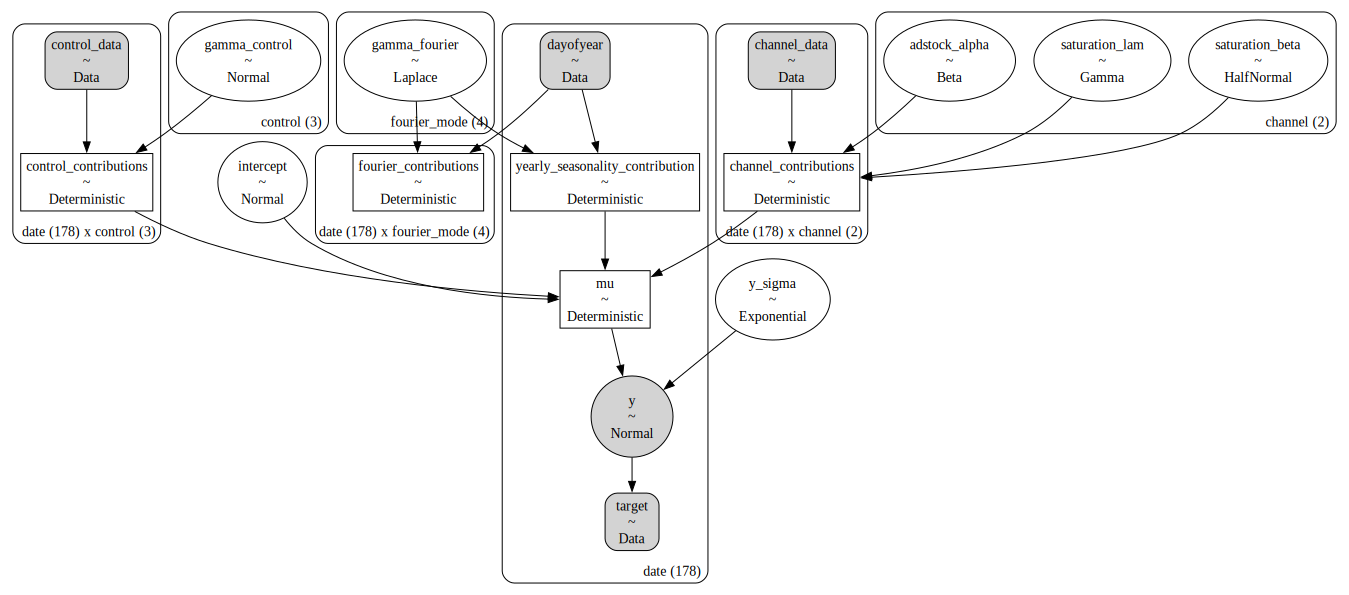

In [60]:
# グラフィカルモデルの可視化
pm.model_to_graphviz(mmm.model)

Sampling: [y]


Output()

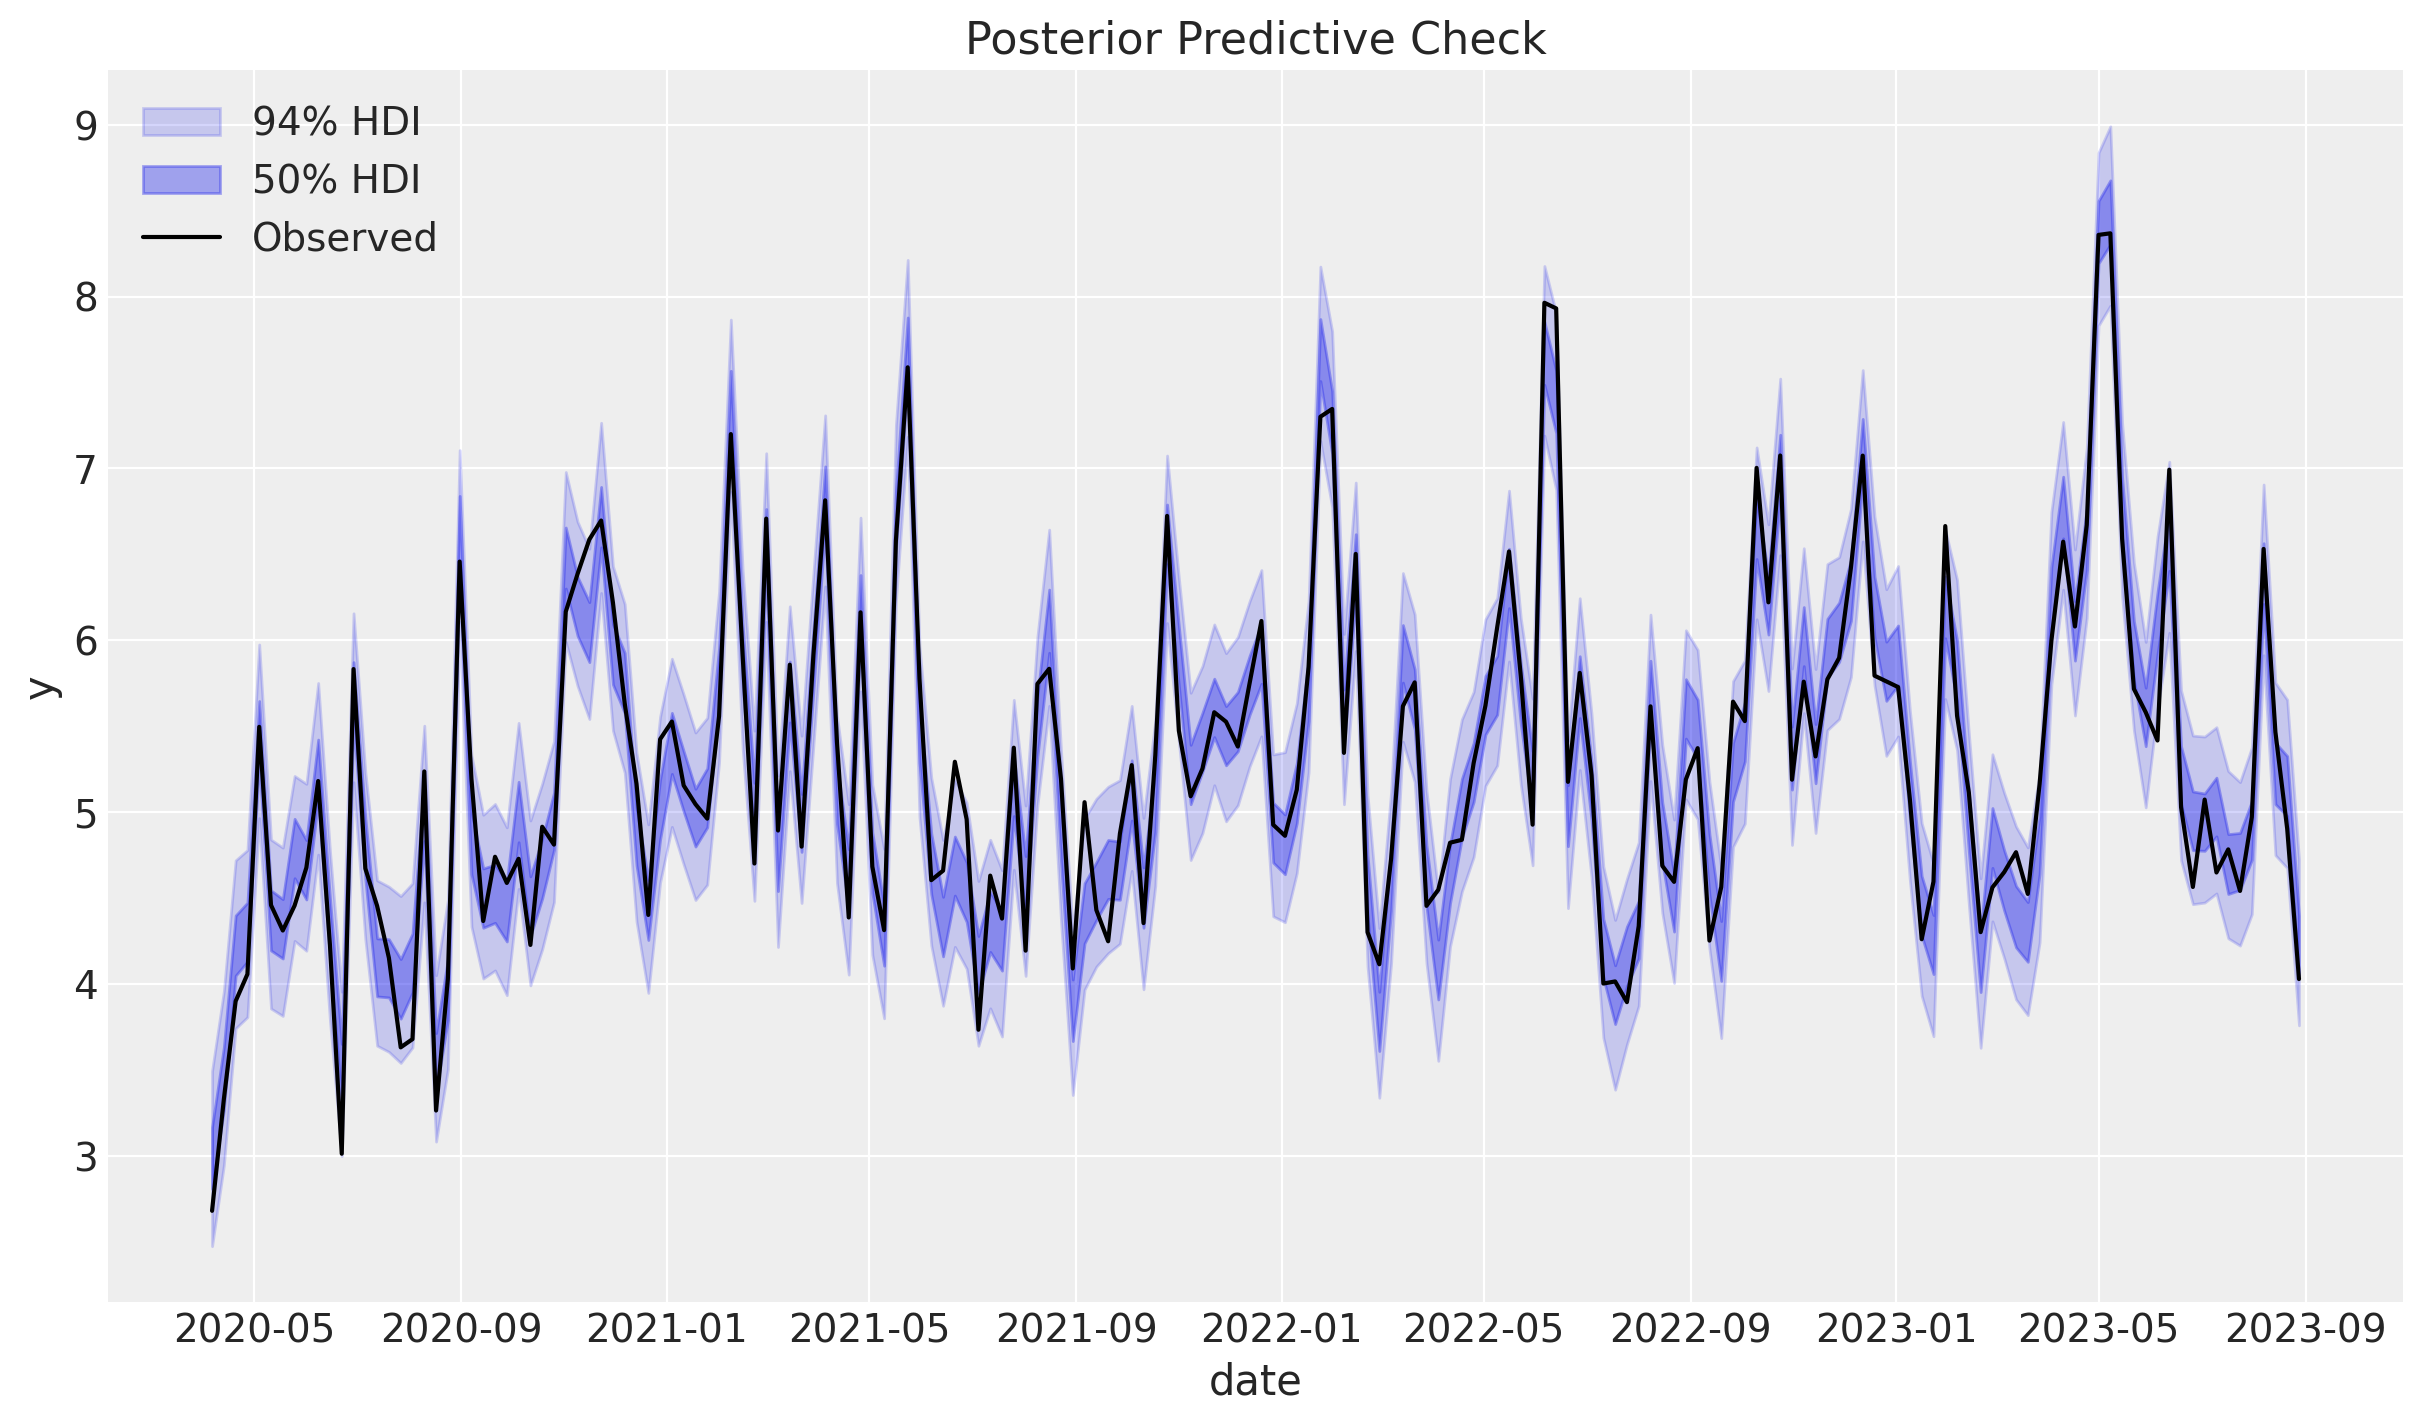

In [44]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)
mmm.plot_posterior_predictive(original_scale=True)

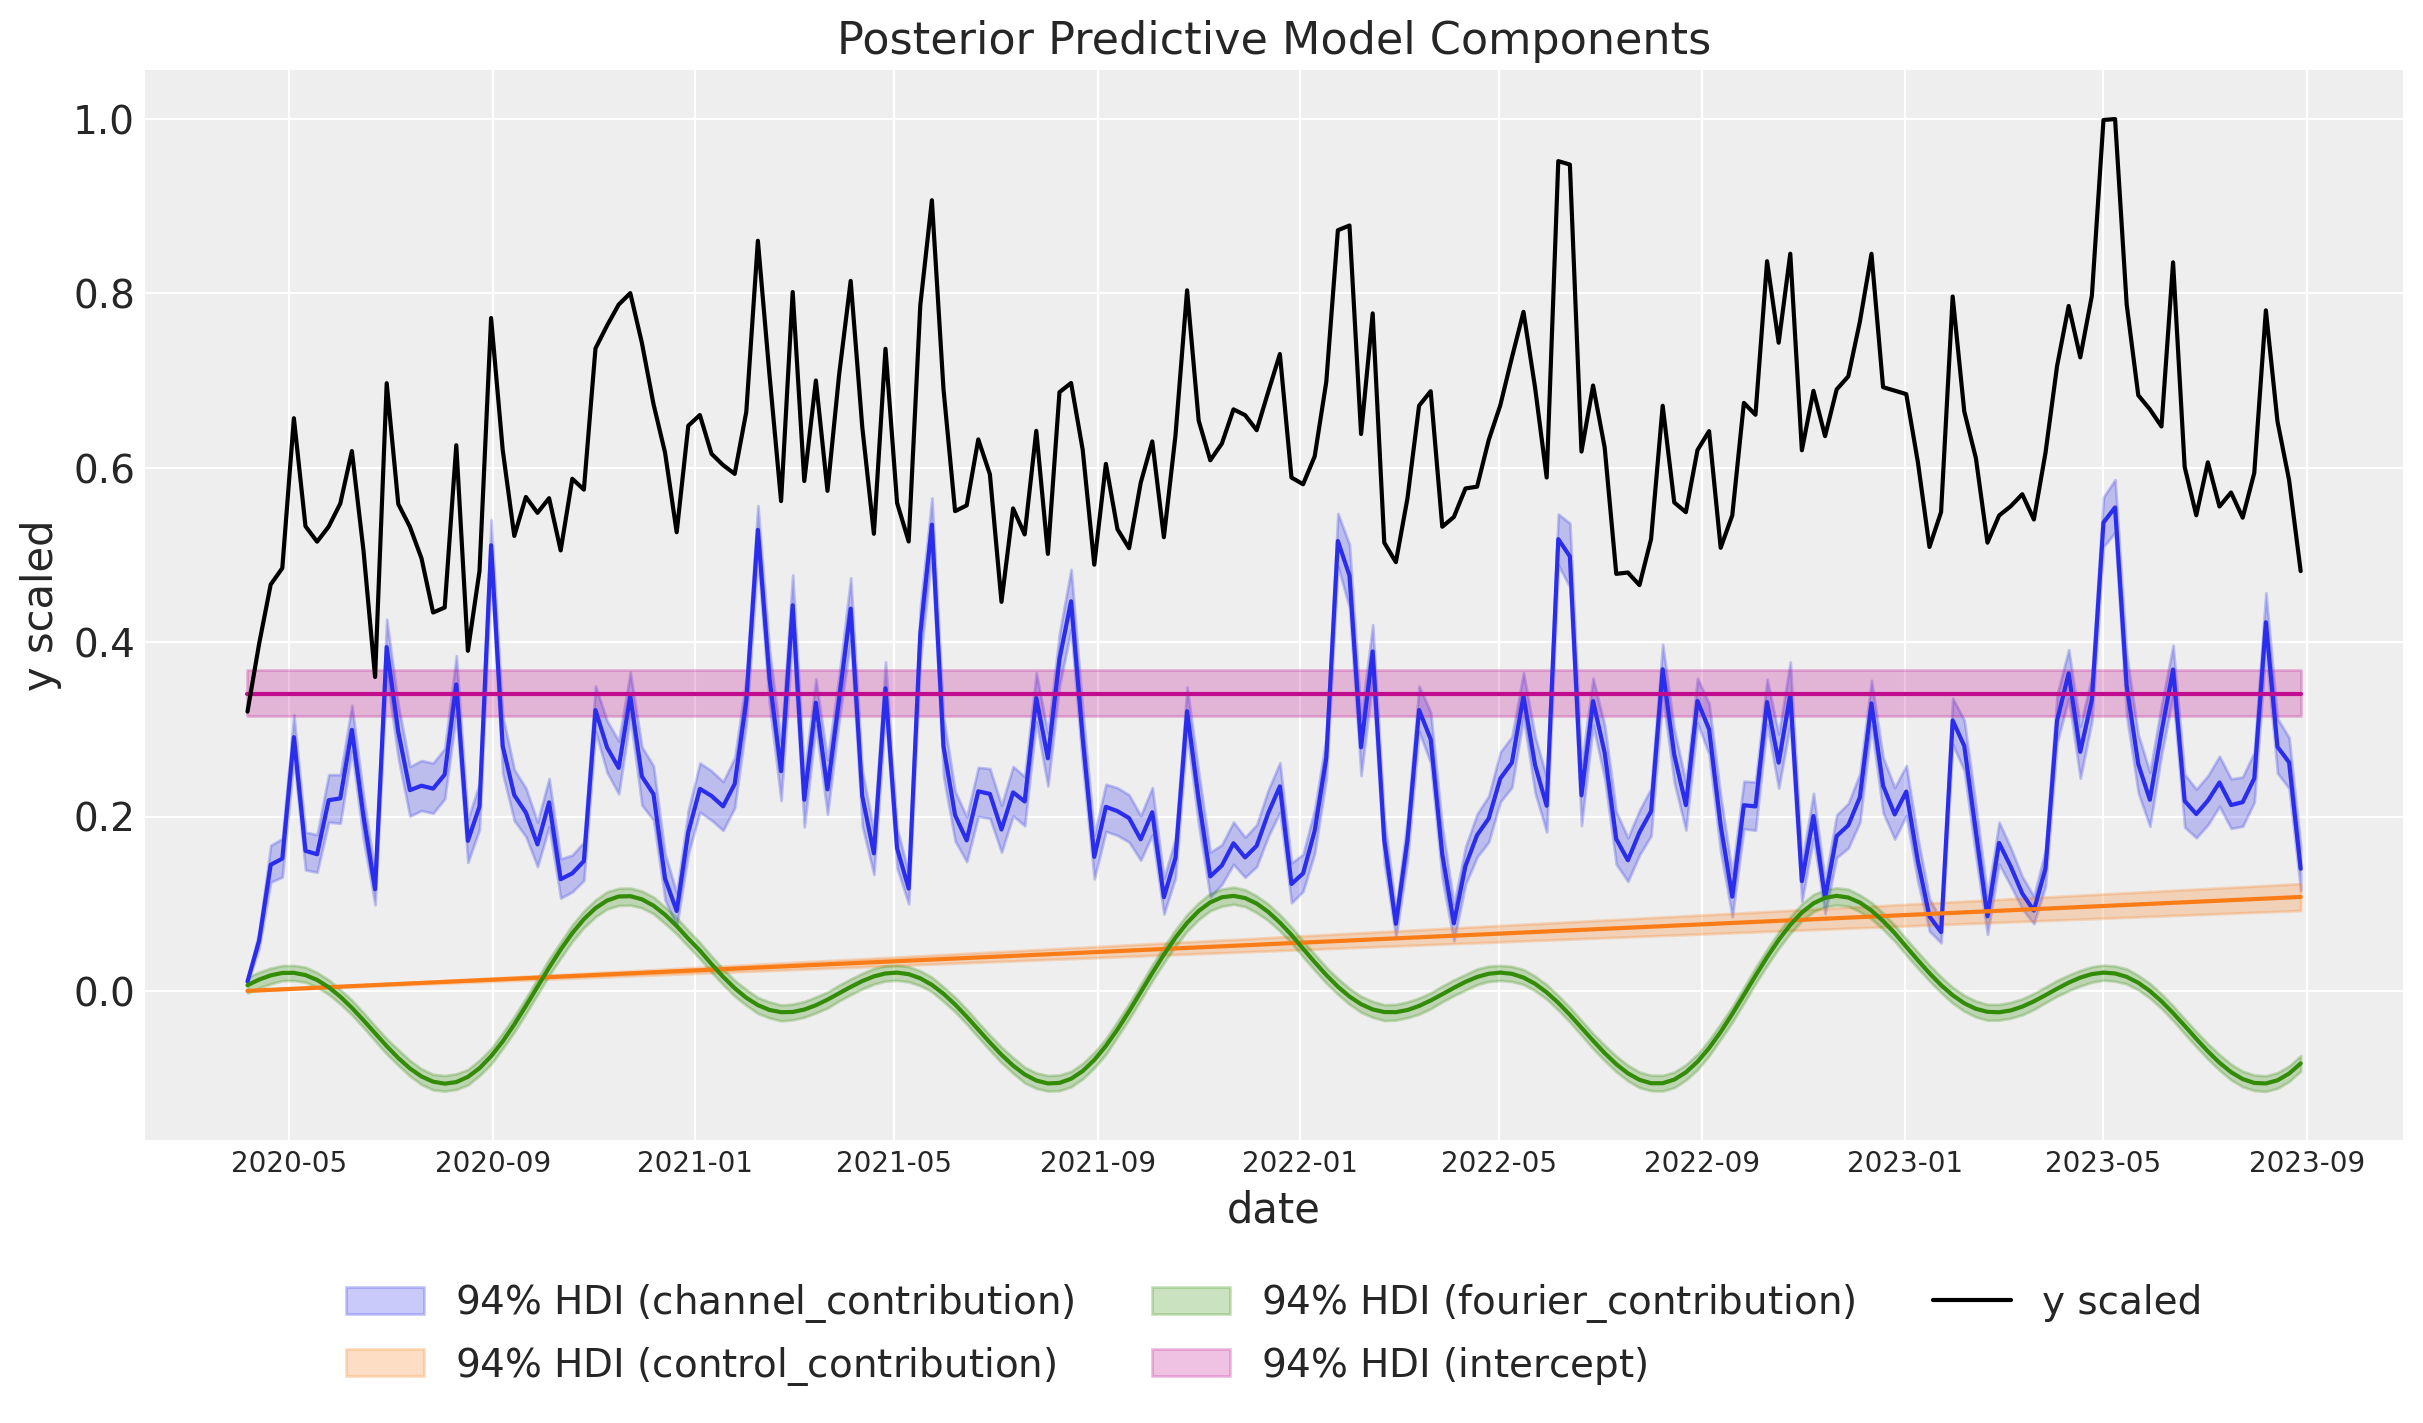

In [45]:
mmm.plot_components_contributions()
plt.tick_params(axis="x", which="major", labelsize=10)

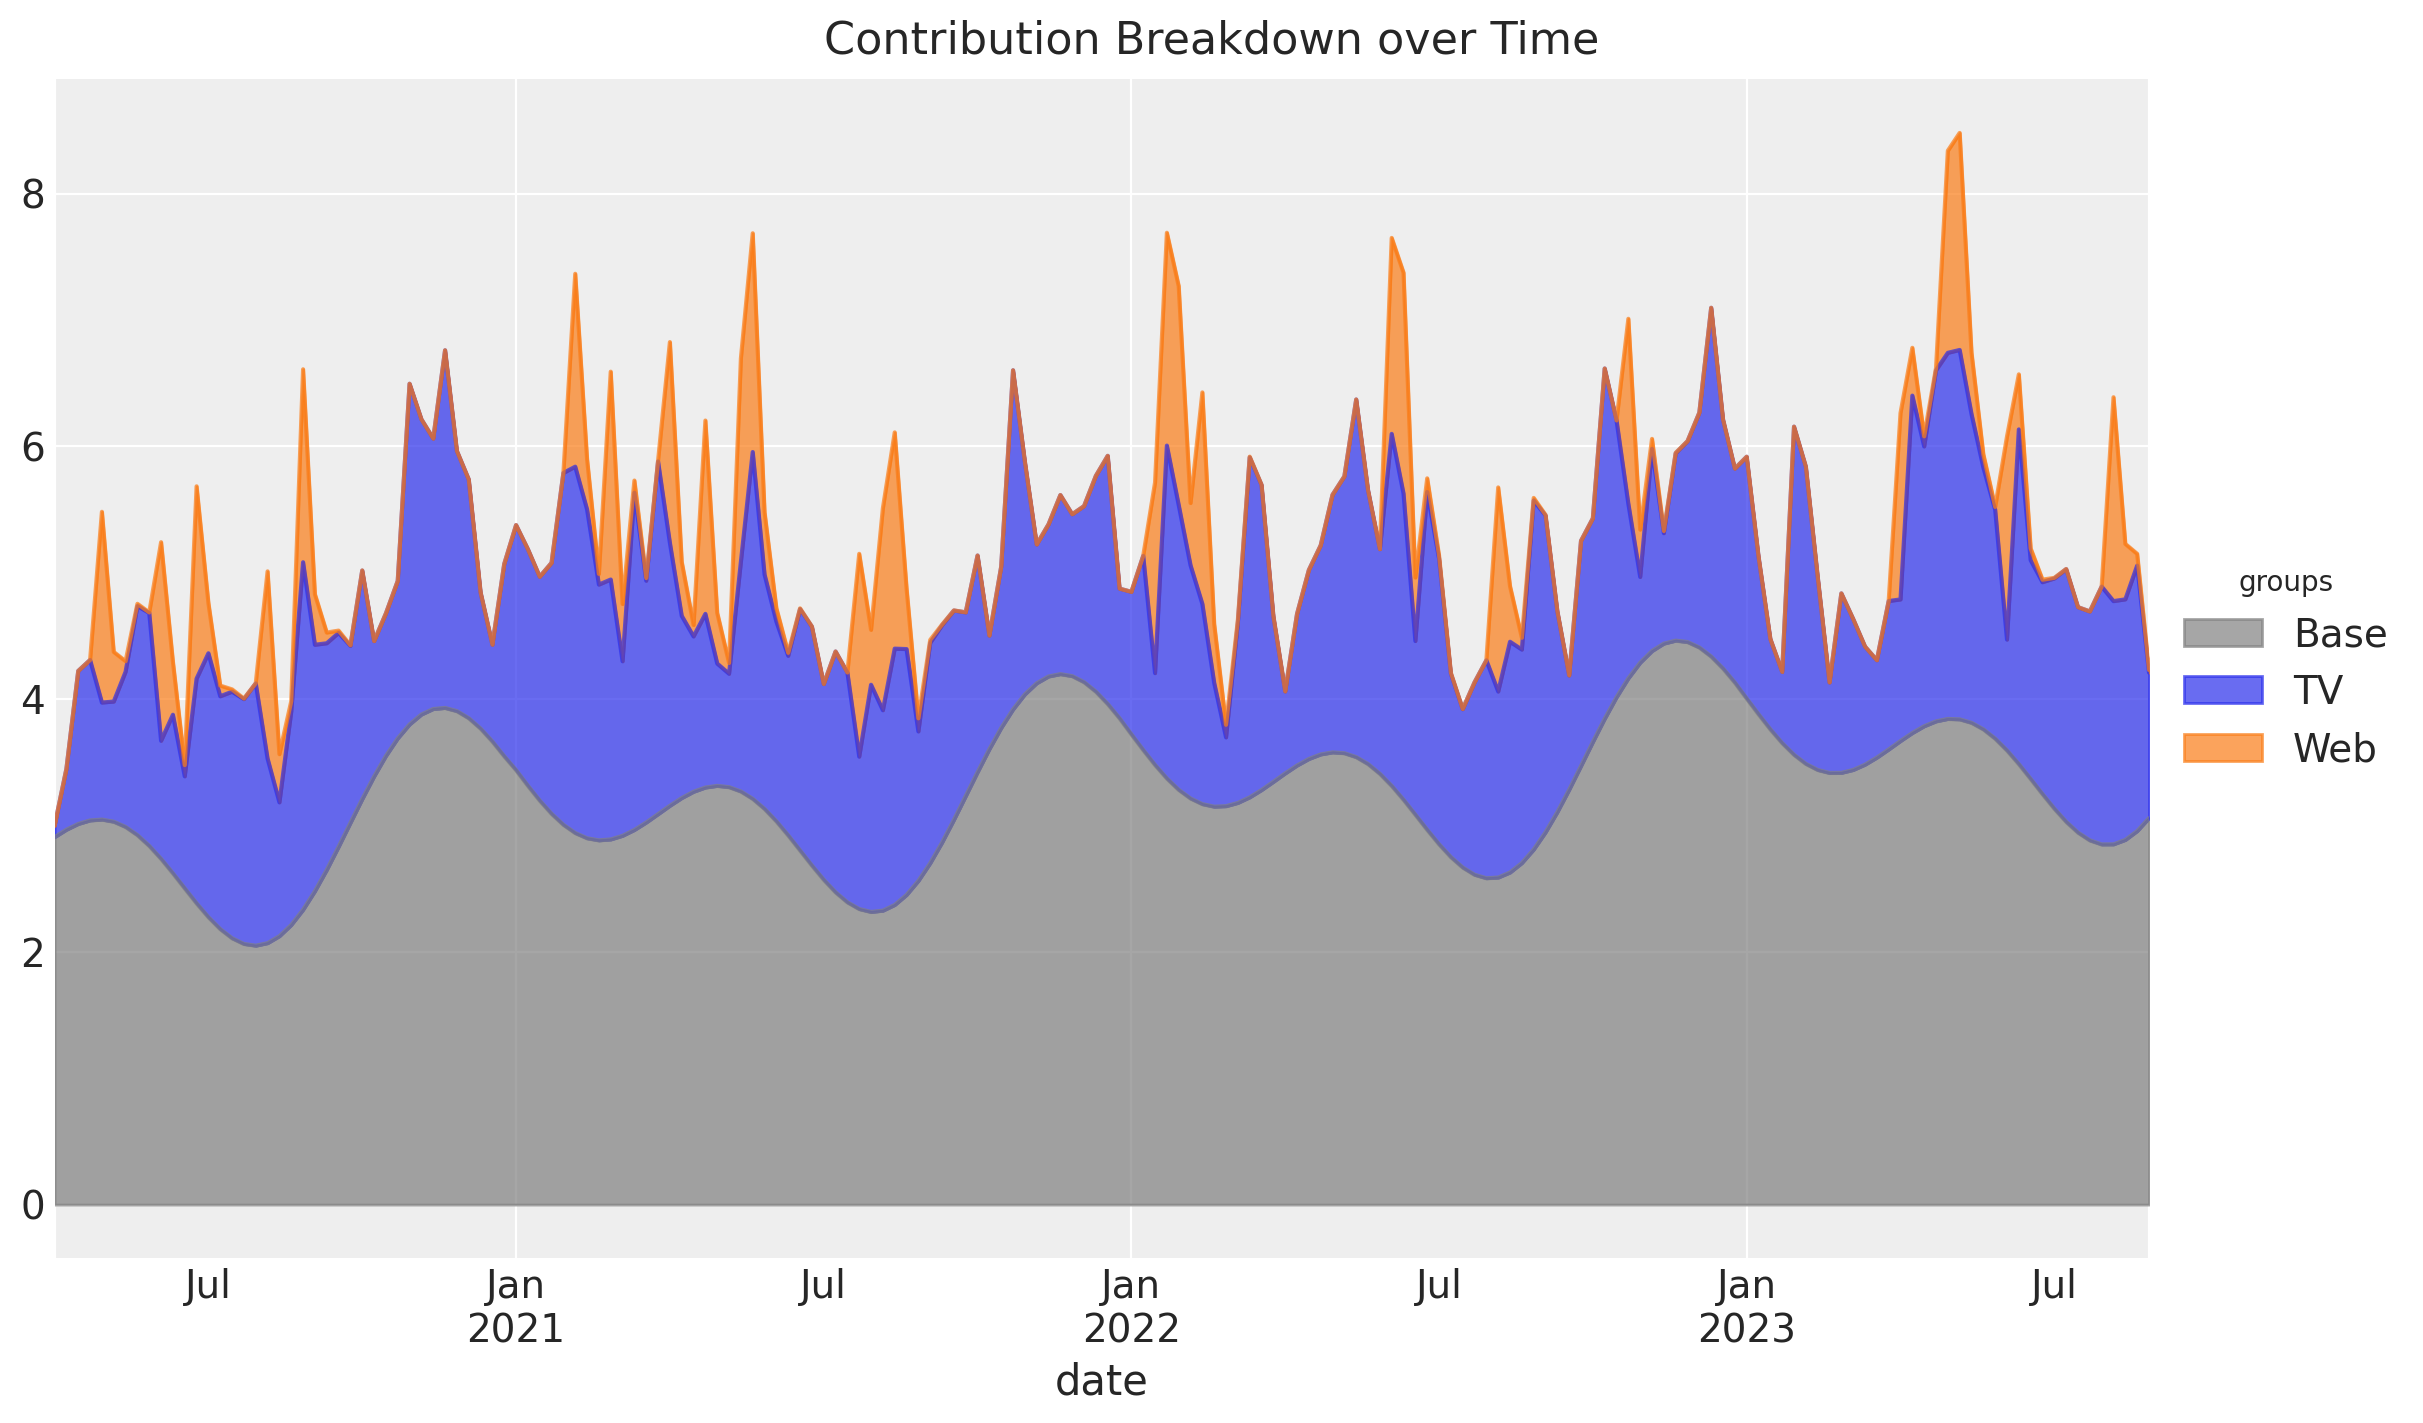

In [47]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "yearly_seasonality",
    ],
    "TV": ["tv"],
    "Web": ["web"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "TV": "C0",
            "Web": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

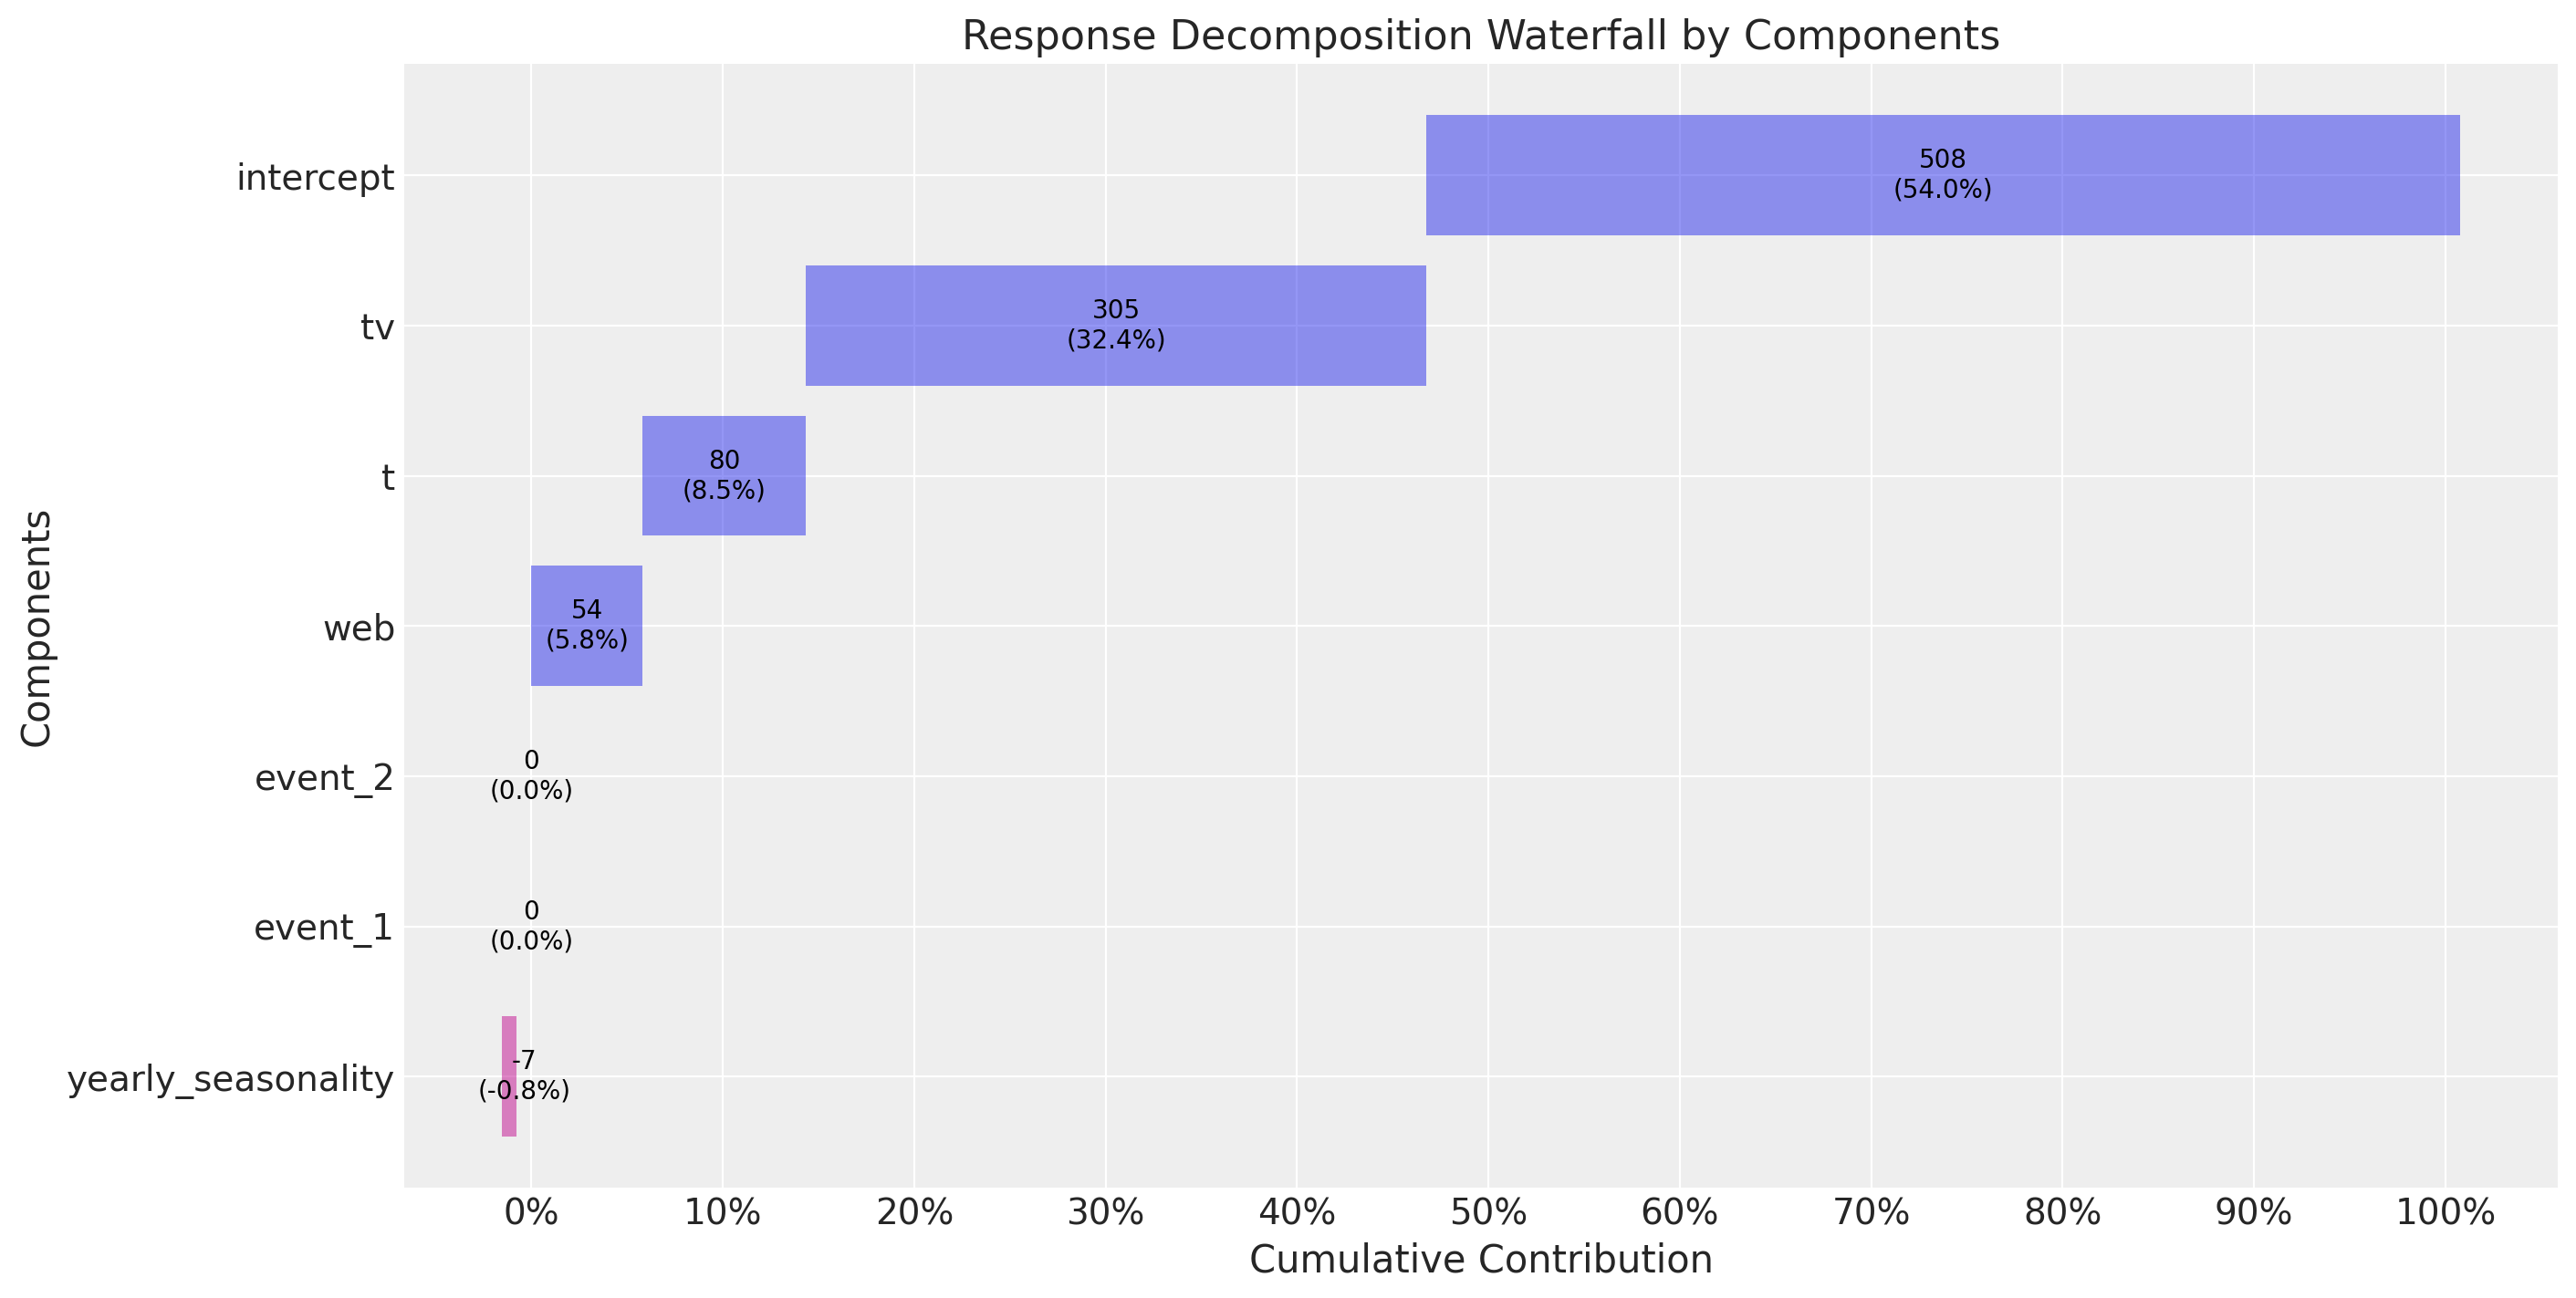

In [50]:
mmm.plot_waterfall_components_decomposition()

In [51]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True,
)

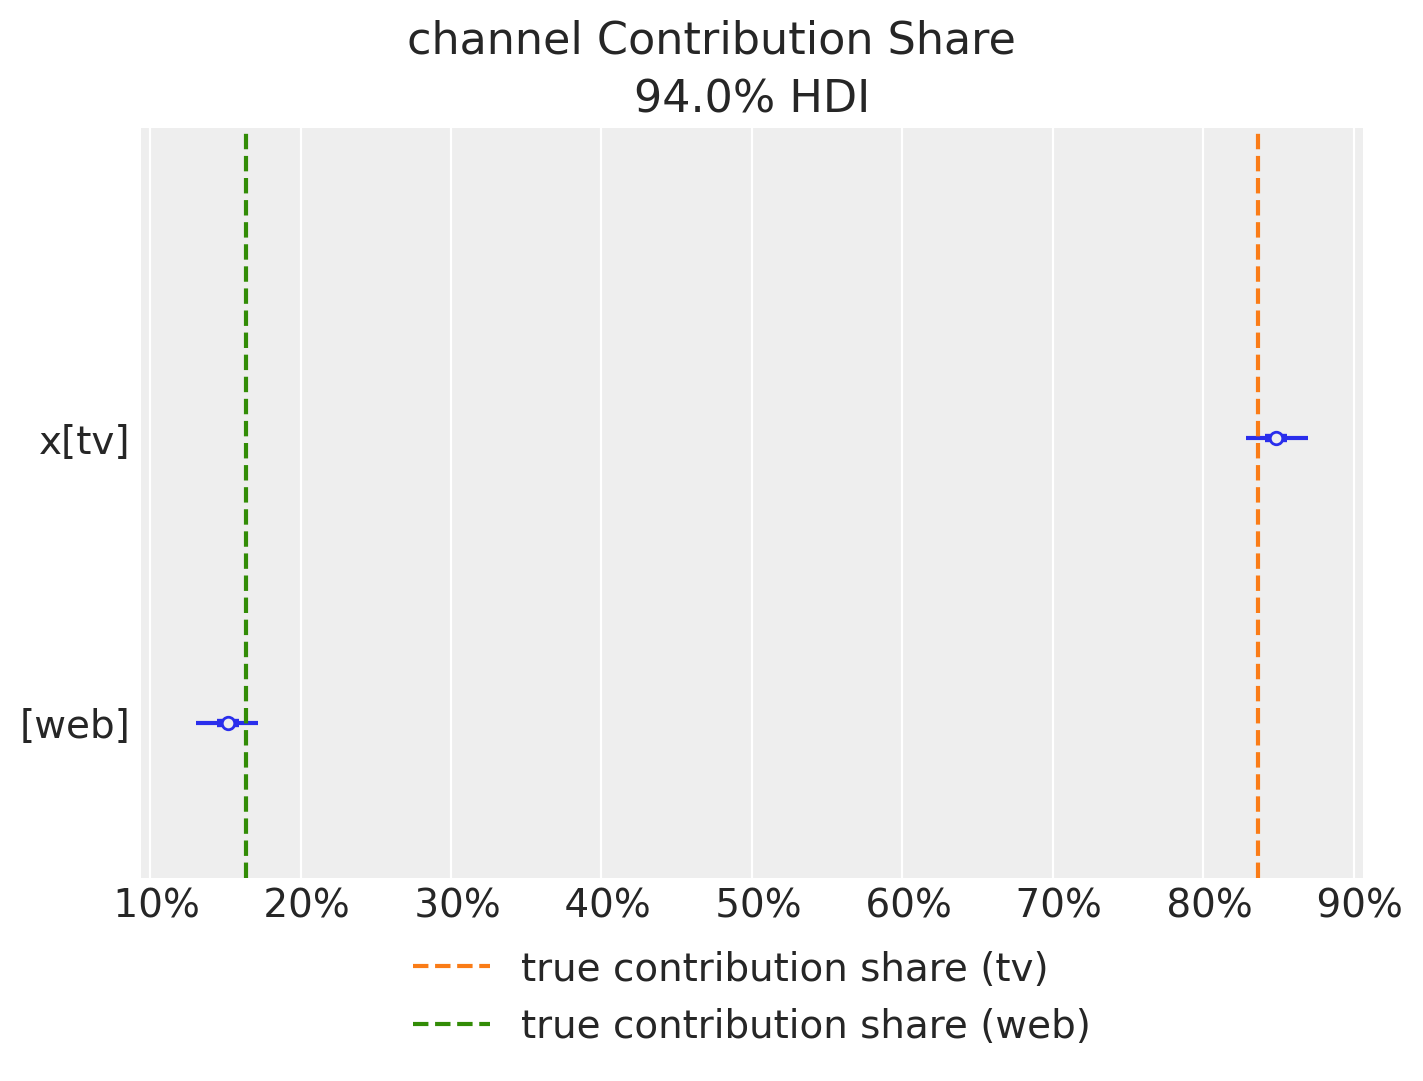

In [52]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_tv,
    color="C1",
    linestyle="--",
    label="true contribution share (tv)",
)
ax.axvline(
    x=contribution_share_web,
    color="C2",
    linestyle="--",
    label="true contribution share (web)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

[Text(0.5, 1.0, 'Posterior ROAS distribution'), Text(0.5, 0, 'ROAS')]

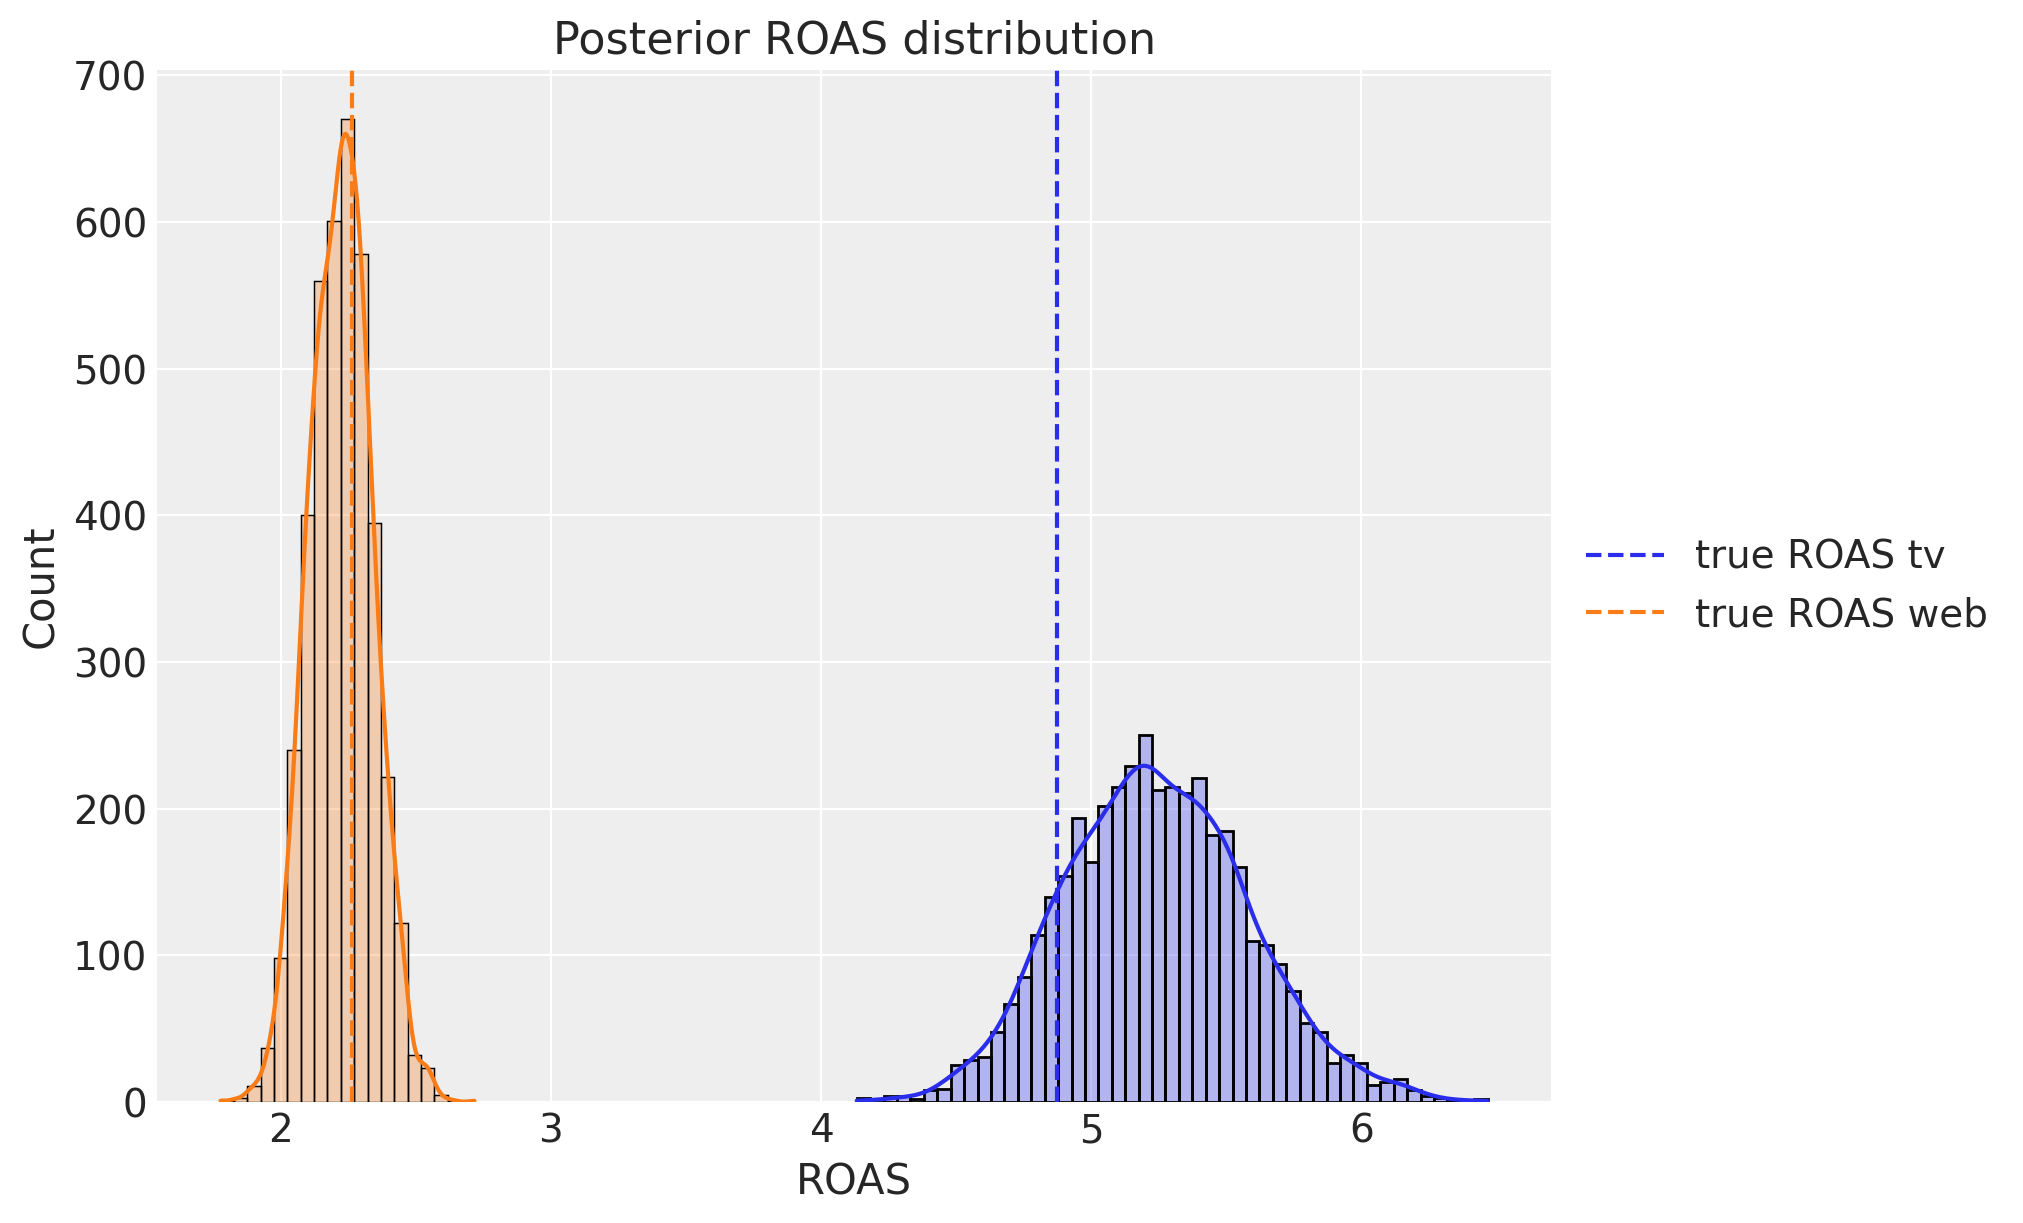

In [54]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")  # noqa: PD013
    / data[["tv", "web"]].sum().to_numpy()[..., None]
)
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="tv").to_numpy(),
    binwidth=0.05,
    alpha=0.3,
    kde=True,
    ax=ax,
)
sns.histplot(
    roas_samples.sel(channel="web").to_numpy(),
    binwidth=0.05,
    alpha=0.3,
    kde=True,
    ax=ax,
)
ax.axvline(x=roas_tv, color="C0", linestyle="--", label=r"true ROAS tv")
ax.axvline(x=roas_web, color="C1", linestyle="--", label=r"true ROAS web")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS")

### 7.5.4 MMMの課題
* 複数の施策が連動し、条件付き独立性が崩れる
* ターゲット層の興味関心が広告支出と売上の両方に寄与している場合、ターゲティングによる選択バイアスが発生する。この場合、ROASの推定結果が誤っている可能性があある。なお、この選択バイアスに対しては、バックドア基準に基づく修正方法が存在し、上記の独立性違反と併せて議論されている
* 分析対象を層別して分析したい場合には、[第5章](../chap5_6/chap5.ipynb#5-因果推論と機械学習の融合)で説明した因果推論と機械学習の使用、もしくは階層ベイズモデルを構築することで、各メディアがサブグループに与える影響を考慮する。

### 因果効果の推定に関する課題
* 個別のデータが無く、全体データしかない場合、3年分のデータとしても月次で12点、週次で156点などデータ数が乏しい
* 同時期に異なるメディアで投下費用を増やすなどメディア間での相関が高い場合。多重共性が発生する可能性がある
* MMMではモデルの構造を関数$f_m$と置くため、この関数の設定の次第で各メディアの影響度合いは変わるため、モデリングに最新の注意が必要。モデルの精度が低ければ当然推定が間違っている可能性がある。
* モデルの精度が高くても、観測データの範囲外の値でのシミュレーションをしようとすると(外挿)、推定がうまくいかない可能性がある。

![図7.33](images/chap7/image-6.png)